# Clustering Stellar Populations

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 11 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

In our exploration of Principal Component Analysis, we discovered how dimension reduction techniques can reveal the underlying structure in high-dimensional astronomical data. Now we turn our attention to another fundamental task in unsupervised learning: clustering—the art of discovering natural groupings within unlabeled data.

Clustering algorithms provide astronomers with powerful tools to identify distinct populations in datasets where we suspect there might be natural groupings. Whether analyzing stellar populations in globular clusters, identifying galaxy types in cosmological surveys, or discovering new classes of astronomical objects, clustering methods allow us to uncover structure that might escape visual inspection, particularly in high-dimensional parameter spaces.

This tutorial explores two foundational clustering algorithms—K-means and Gaussian Mixture Models (GMMs)—through the lens of stellar chemical abundances in the Sculptor dwarf spheroidal galaxy. We'll build these methods from scratch to develop deep intuition about their mathematical foundations and practical limitations.

The astrophysical context for our analysis comes from recent discoveries about episodic star formation in dwarf galaxies, as presented in ["Quantifying Bursty Star Formation in Dwarf Galaxies"](https://ui.adsabs.harvard.edu/abs/2025OJAp....8E...7T/abstract) (Ting & Ji, 2025). When star formation occurs in bursts followed by quiescent periods, distinct stellar populations form with characteristic chemical signatures. These populations manifest as clusters in chemical abundance space, making clustering algorithms ideal tools for uncovering a galaxy's bursty star formation history.

Through this tutorial, we'll see how the choice between K-means and GMMs reflects fundamental assumptions about the nature of our clusters. K-means assumes spherical, equally-sized clusters with hard boundaries—each star belongs to exactly one population. GMMs relax these assumptions, allowing for elliptical clusters of varying sizes with probabilistic membership—acknowledging that stellar populations may overlap in chemical abundance space.

This progression from K-means to GMMs mirrors a broader theme in statistical machine learning: starting with simple, interpretable models and gradually introducing complexity to better capture the nuances of real astronomical data.


## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Python Programming**: Proficiency with NumPy arrays, matplotlib visualization, and scipy functionality
- **Linear Algebra**: Understanding of matrix operations, eigenvalues, and covariance matrices
- **Probability Theory**: Knowledge of multivariate Gaussian distributions and maximum likelihood estimation
- **Statistical Concepts**: Familiarity with the Expectation-Maximization (EM) algorithm framework

From Chapter 11 of the textbook, you should understand:
- The mathematical formulation of K-means as an optimization problem
- The theoretical foundations of Gaussian Mixture Models
- The EM algorithm's iterative refinement of model parameters
- Information criteria (AIC, BIC) for model selection

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Algorithm Implementation**: Building K-means and GMM algorithms from first principles, understanding each computational step
- **Initialization Strategies**: Implementing both random and K-means++ initialization methods and understanding their impact on convergence
- **Convergence Analysis**: Tracking and visualizing how clustering algorithms iteratively refine their solutions
- **Model Selection**: Applying information criteria to determine optimal cluster numbers in real astronomical data
- **Astrophysical Interpretation**: Connecting clustering results to physical processes in galaxy evolution

We begin by importing the necessary libraries and configuring our computational environment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.cm as cm
import matplotlib.patches as patches

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## Astrophysical Background: Episodic Star Formation in Dwarf Galaxies

The chemical abundances of stars serve as archaeological records, preserving information about the conditions in which they formed billions of years ago. This tutorial leverages this principle to explore clustering algorithms through a compelling astrophysical application: detecting evidence of episodic star formation in the Sculptor dwarf spheroidal galaxy.

### Chemical Abundances as Stellar Clocks

Stars inherit their chemical composition from the interstellar medium at the time of their formation. As a galaxy evolves, successive generations of stars enrich this medium through supernovae, gradually increasing the abundance of heavy elements. This process creates a chemical timeline that we can read through spectroscopic observations.

Two key abundance ratios anchor our analysis:

**[Fe/H] - Iron-to-Hydrogen Ratio**  
This logarithmic ratio relative to solar abundances serves as our primary metallicity indicator. Iron accumulates steadily over cosmic time through both core-collapse supernovae (from massive stars) and Type Ia supernovae (from white dwarf explosions). Thus, [Fe/H] broadly tracks the progression of star formation—stars with higher [Fe/H] generally formed later in a galaxy's history.

**[Mg/Fe] - Magnesium-to-Iron Ratio**  
This ratio reveals the relative contributions of different supernova types. Core-collapse supernovae produce α-elements like magnesium on short timescales (~10 Myr), while Type Ia supernovae predominantly yield iron after longer delays (~100 Myr to 1 Gyr). The [Mg/Fe] ratio thus encodes timing information about star formation episodes.

### The Signature of Bursty Star Formation

Continuous star formation produces a smooth track in the [Mg/Fe]-[Fe/H] plane, as both elements increase gradually over time. However, episodic star formation creates a distinctive pattern, as demonstrated by Ting & Ji (2025):

1. **Active Phase**: During a starburst, core-collapse supernovae rapidly enrich the interstellar medium with both magnesium and iron, maintaining relatively high [Mg/Fe] ratios.

2. **Quiescent Phase**: When star formation ceases, massive stars no longer form, eliminating core-collapse supernovae. However, Type Ia supernovae from earlier stellar generations continue to explode, injecting iron but minimal magnesium. This drives [Mg/Fe] ratios downward at roughly constant [Fe/H].

3. **Renewed Activity**: When star formation resumes, new stars form from iron-enriched gas with depleted [Mg/Fe]. This creates a discontinuous jump to higher [Fe/H] values—a chemical "gap" marking the quiescent period.

These gaps in chemical space translate directly to gaps in time, with the iron enrichment during quiescence providing a chemical clock. For Sculptor, the observed multimodality suggests burst-quiescence cycles of approximately 300 Myr, offering refined temporal resolution beyond traditional color-magnitude diagram analyses.

The challenge lies in objectively identifying these distinct stellar populations. Visual inspection becomes unreliable, especially when populations overlap or when working in higher-dimensional chemical spaces. This motivates our exploration of clustering algorithms—quantitative tools that can identify and characterize these chemically distinct groups, transforming stellar chemistry into a precise probe of galaxy formation history.

## The Sculptor Dataset

We begin our analysis with spectroscopic data from the Sculptor dwarf spheroidal galaxy, one of the Milky Way's satellite galaxies located approximately 290,000 light-years away. As a relatively isolated system with a simple dynamical structure, Sculptor provides an ideal laboratory for studying the chemical evolution of dwarf galaxies.

The dataset contains high-resolution spectroscopic measurements from the Apache Point Observatory Galactic Evolution Experiment (APOGEE), providing precise chemical abundances for individual stars. These measurements allow us to construct a detailed view of Sculptor's chemical evolution history through the distribution of its stars in abundance space.

Let's load the data and perform an initial exploration to understand its structure:

Successfully loaded dataset with 143 stars
Available columns: FE_H, MG_FE

Chemical abundance statistics:
[Fe/H] range: [-2.41, -0.90]
[Mg/Fe] range: [-0.60, 0.41]
Mean [Fe/H]: -1.58 ± 0.36
Mean [Mg/Fe]: -0.03 ± 0.23


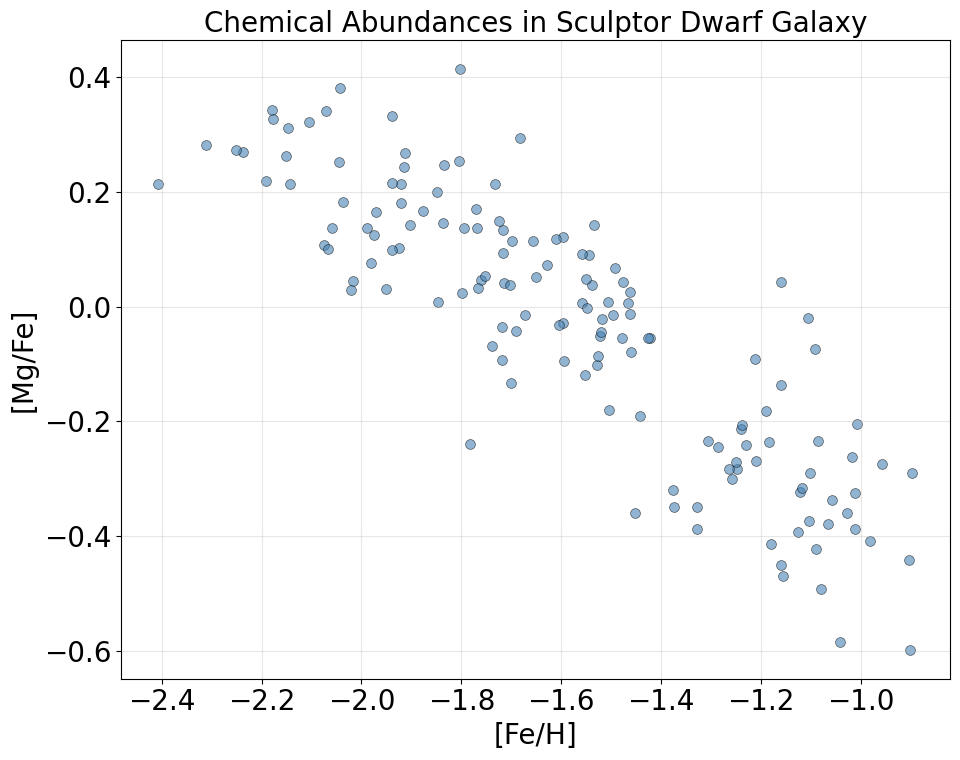

In [2]:
# Load the Sculptor dwarf galaxy data
data = pd.read_csv("dataset_apogee_sculptor.csv")
print(f"Successfully loaded dataset with {len(data)} stars")
print(f"Available columns: {', '.join(data.columns)}")

# Extract chemical abundances as NumPy array for our algorithms
X = data[['FE_H', 'MG_FE']].values

# Display basic statistics
print("\nChemical abundance statistics:")
print(f"[Fe/H] range: [{np.min(X[:, 0]):.2f}, {np.max(X[:, 0]):.2f}]")
print(f"[Mg/Fe] range: [{np.min(X[:, 1]):.2f}, {np.max(X[:, 1]):.2f}]")
print(f"Mean [Fe/H]: {np.mean(X[:, 0]):.2f} ± {np.std(X[:, 0]):.2f}")
print(f"Mean [Mg/Fe]: {np.mean(X[:, 1]):.2f} ± {np.std(X[:, 1]):.2f}")

# Initial visualization of the chemical abundance distribution
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6, s=50, c='steelblue', edgecolor='k', linewidth=0.5)
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.title('Chemical Abundances in Sculptor Dwarf Galaxy')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The scatter plot reveals intriguing structure in Sculptor's chemical abundance distribution. Rather than forming a smooth, continuous sequence—as would be expected from steady star formation—the data hints at multiple overdense regions and possible gaps in the [Fe/H]-[Mg/Fe] plane.

Several features merit attention:

1. **Non-uniform Distribution**: The stellar density varies across the abundance plane, with apparent concentrations at specific [Fe/H] and [Mg/Fe] values.

2. **Potential Multimodality**: Visual inspection suggests the presence of multiple groups, though the boundaries between these groups are not immediately clear.

3. **Chemical Evolution Track**: The overall trend from high [Mg/Fe] at low [Fe/H] to lower [Mg/Fe] at higher [Fe/H] follows the expected pattern of galactic chemical evolution, but with notable deviations from a smooth decline.

These observations align with the theoretical predictions for episodic star formation. However, visual identification of distinct populations becomes subjective and unreliable, particularly when:
- Populations overlap in chemical space
- The number of distinct groups is unclear
- We need quantitative measures of group membership

This motivates our systematic application of clustering algorithms. By treating each star's position in the [Fe/H]-[Mg/Fe] plane as a two-dimensional data point, we can leverage K-means and Gaussian Mixture Models to:
- Objectively identify distinct stellar populations
- Quantify the statistical significance of apparent groupings
- Assign probabilistic membership to potentially overlapping populations
- Determine the optimal number of populations supported by the data

We begin with K-means clustering, which provides a conceptually straightforward approach to partitioning our data into distinct groups.

## K-means Clustering from Scratch

K-means represents one of the most fundamental clustering algorithms in machine learning, elegant in its simplicity yet powerful in its applications. The algorithm partitions data into K clusters by iteratively refining cluster assignments to minimize within-cluster variance—a process that naturally identifies groups of similar objects.

At its core, K-means seeks to solve an optimization problem. Given a dataset $\{\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N\}$ and a desired number of clusters $K$, we aim to minimize the total within-cluster sum of squares:

$$J = \sum_{n=1}^N \sum_{k=1}^K r_{nk} ||\mathbf{x}_n - \boldsymbol{\mu}_k||^2$$

where $r_{nk} \in \{0, 1\}$ indicates whether data point $n$ belongs to cluster $k$, and $\boldsymbol{\mu}_k$ represents the centroid of cluster $k$. Each point belongs to exactly one cluster, enforcing the constraint $\sum_{k=1}^K r_{nk} = 1$.

This optimization problem, while conceptually simple, is NP-hard in its general form. The K-means algorithm provides an efficient heuristic solution through alternating optimization—fixing cluster assignments while updating centroids, then fixing centroids while updating assignments. This iterative refinement, an instance of the Expectation-Maximization framework, guarantees convergence to a local minimum.

Before applying K-means to our stellar abundances, we must address a crucial consideration: scale sensitivity. K-means relies on Euclidean distances, making it sensitive to the relative scales of different features. Without standardization, features with larger numerical ranges would dominate the distance calculations, potentially obscuring meaningful patterns. For our chemical abundances, standardization ensures both [Fe/H] and [Mg/Fe] contribute equally to cluster identification:

Original data statistics:
[Fe/H]: mean = -1.578, std = 0.364
[Mg/Fe]: mean = -0.033, std = 0.230


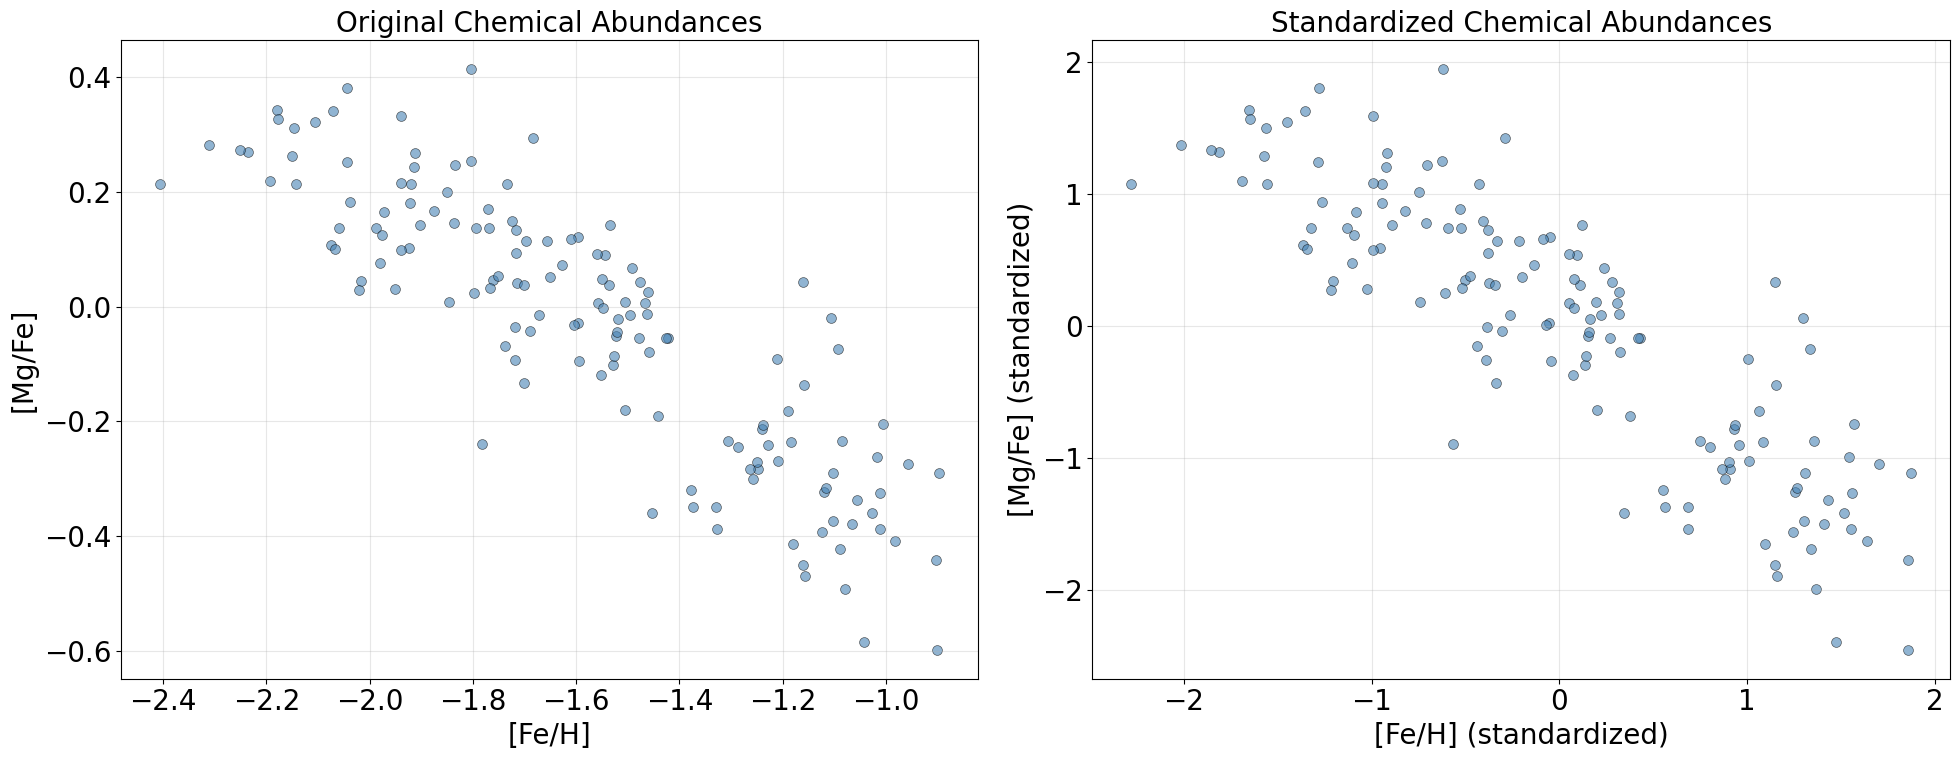

In [3]:
def standardize(X):
    """
    Standardize features to have zero mean and unit variance
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
        
    Returns:
    --------
    X_std : array, shape (n_samples, n_features)
        Standardized data
    mean : array, shape (n_features,)
        Feature means
    std : array, shape (n_features,)
        Feature standard deviations
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std, mean, std

# Standardize our data
X_std, mean_X, std_X = standardize(X)

print("Original data statistics:")
print(f"[Fe/H]: mean = {mean_X[0]:.3f}, std = {std_X[0]:.3f}")
print(f"[Mg/Fe]: mean = {mean_X[1]:.3f}, std = {std_X[1]:.3f}")

# Visualize the effect of standardization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Original data
ax1.scatter(X[:, 0], X[:, 1], alpha=0.6, s=50, c='steelblue', edgecolor='k', linewidth=0.5)
ax1.set_xlabel('[Fe/H]')
ax1.set_ylabel('[Mg/Fe]')
ax1.set_title('Original Chemical Abundances')
ax1.grid(True, alpha=0.3)

# Standardized data
ax2.scatter(X_std[:, 0], X_std[:, 1], alpha=0.6, s=50, c='steelblue', edgecolor='k', linewidth=0.5)
ax2.set_xlabel('[Fe/H] (standardized)')
ax2.set_ylabel('[Mg/Fe] (standardized)')
ax2.set_title('Standardized Chemical Abundances')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Initialization Strategies for K-means

The initialization of cluster centroids profoundly impacts K-means performance. Poor initialization can lead to suboptimal clustering, slow convergence, or inconsistent results across different runs. We'll implement two initialization strategies that illustrate this challenge and its solution.

**Random Initialization** represents the simplest approach: select K data points at random as initial centroids. While straightforward, this method suffers from high variability. Centroids may cluster in one region of the data space, leading to poor initial partitions that the algorithm struggles to escape.

**K-means++** provides a more sophisticated initialization that spreads centroids across the data space. The algorithm proceeds iteratively:
1. Choose the first centroid uniformly at random from the data points
2. For each subsequent centroid, select points with probability proportional to their squared distance from the nearest existing centroid
3. Repeat until K centroids are selected

This probabilistic selection favors points in underrepresented regions, producing well-separated initial centroids that typically lead to better final clusterings. The theoretical guarantee—that K-means++ achieves an expected approximation ratio of O(log k) to the optimal clustering—translates to practical benefits of faster convergence and more stable results.

Let's implement both methods and visualize their behavior on our stellar abundance data:

In [4]:
def init_random(X, k, random_state=None):
    """
    Initialize k centroids randomly from data points
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of clusters
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    centroids : array, shape (k, n_features)
        The initial centroids
    """
    if random_state is not None:
        np.random.seed(random_state)
        
    # Randomly select k data points as centroids
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices].copy()

def init_kmeans_plus_plus(X, k, random_state=None):
    """
    Initialize centroids using the K-means++ method
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of clusters
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    centroids : array, shape (k, n_features)
        The initial centroids
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples, n_features = X.shape
    centroids = np.zeros((k, n_features))
    
    # Choose first centroid randomly
    first_idx = np.random.choice(n_samples)
    centroids[0] = X[first_idx]
    
    # Choose remaining centroids
    for c in range(1, k):
        # Compute squared distances to nearest centroid
        min_distances = np.full(n_samples, np.inf)
        
        for i in range(c):
            distances = np.sum((X - centroids[i])**2, axis=1)
            min_distances = np.minimum(min_distances, distances)
        
        # Choose next centroid with probability proportional to squared distance
        probabilities = min_distances / np.sum(min_distances)
        next_idx = np.random.choice(n_samples, p=probabilities)
        centroids[c] = X[next_idx]
    
    return centroids

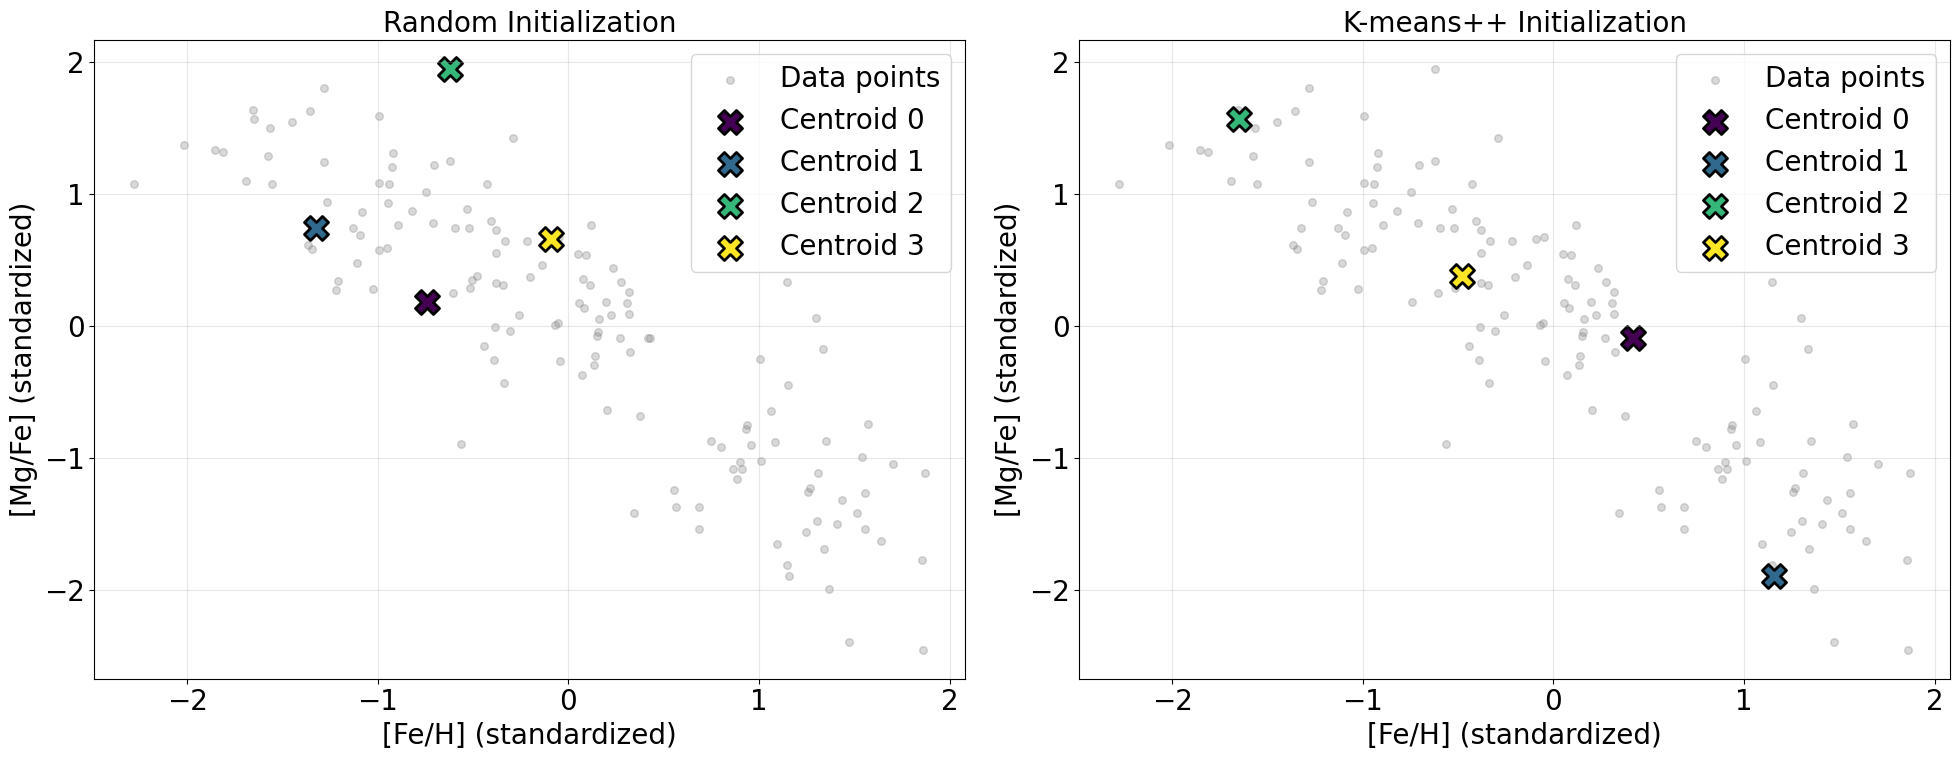

Minimum pairwise distances between centroids:
Random initialization: 0.807
K-means++ initialization: 1.011


In [5]:
# Compare initialization methods with k=4 clusters
k = 4
random_centroids = init_random(X_std, k=k, random_state=42)
kmeans_pp_centroids = init_kmeans_plus_plus(X_std, k=k, random_state=42)

# Visualize both initialization methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Random initialization
ax1.scatter(X_std[:, 0], X_std[:, 1], alpha=0.3, s=30, c='gray', label='Data points')
colors = plt.cm.viridis(np.linspace(0, 1, k))
for i in range(k):
    ax1.scatter(random_centroids[i, 0], random_centroids[i, 1], 
               c=[colors[i]], s=300, marker='X', edgecolor='black', 
               linewidth=2, label=f'Centroid {i}')
ax1.set_xlabel('[Fe/H] (standardized)')
ax1.set_ylabel('[Mg/Fe] (standardized)')
ax1.set_title('Random Initialization')
ax1.legend()
ax1.grid(True, alpha=0.3)

# K-means++ initialization
ax2.scatter(X_std[:, 0], X_std[:, 1], alpha=0.3, s=30, c='gray', label='Data points')
for i in range(k):
    ax2.scatter(kmeans_pp_centroids[i, 0], kmeans_pp_centroids[i, 1], 
               c=[colors[i]], s=300, marker='X', edgecolor='black', 
               linewidth=2, label=f'Centroid {i}')
ax2.set_xlabel('[Fe/H] (standardized)')
ax2.set_ylabel('[Mg/Fe] (standardized)')
ax2.set_title('K-means++ Initialization')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute pairwise distances between initial centroids
print("Minimum pairwise distances between centroids:")
print(f"Random initialization: {np.min([np.linalg.norm(random_centroids[i] - random_centroids[j]) 
                                      for i in range(k) for j in range(i+1, k)]):.3f}")
print(f"K-means++ initialization: {np.min([np.linalg.norm(kmeans_pp_centroids[i] - kmeans_pp_centroids[j]) 
                                         for i in range(k) for j in range(i+1, k)]):.3f}")

## The Expectation-Maximization Framework for K-means

The K-means algorithm elegantly solves its optimization problem through alternating minimization, a special case of the Expectation-Maximization (EM) algorithm. This iterative approach alternates between two steps that progressively refine the clustering:

**E-step (Expectation)**: Given fixed centroids, assign each data point to its nearest centroid. This step computes the "expected" cluster membership under the current model parameters.

**M-step (Maximization)**: Given fixed assignments, update each centroid to the mean of its assigned points. This step finds the centroid positions that maximize the fit to the assigned data.

The beauty of this approach lies in its guarantee: each step either improves the objective function or leaves it unchanged, ensuring convergence to a local minimum. While this local minimum may not be globally optimal—hence the importance of good initialization—the algorithm's efficiency and interpretability have made it a cornerstone of unsupervised learning.

Let's implement the E-step, which assigns each star to its nearest centroid based on Euclidean distance in our standardized abundance space:


Initial cluster assignments:
  Cluster 0: 37 stars (25.9%)
  Cluster 1: 35 stars (24.5%)
  Cluster 2: 21 stars (14.7%)
  Cluster 3: 50 stars (35.0%)


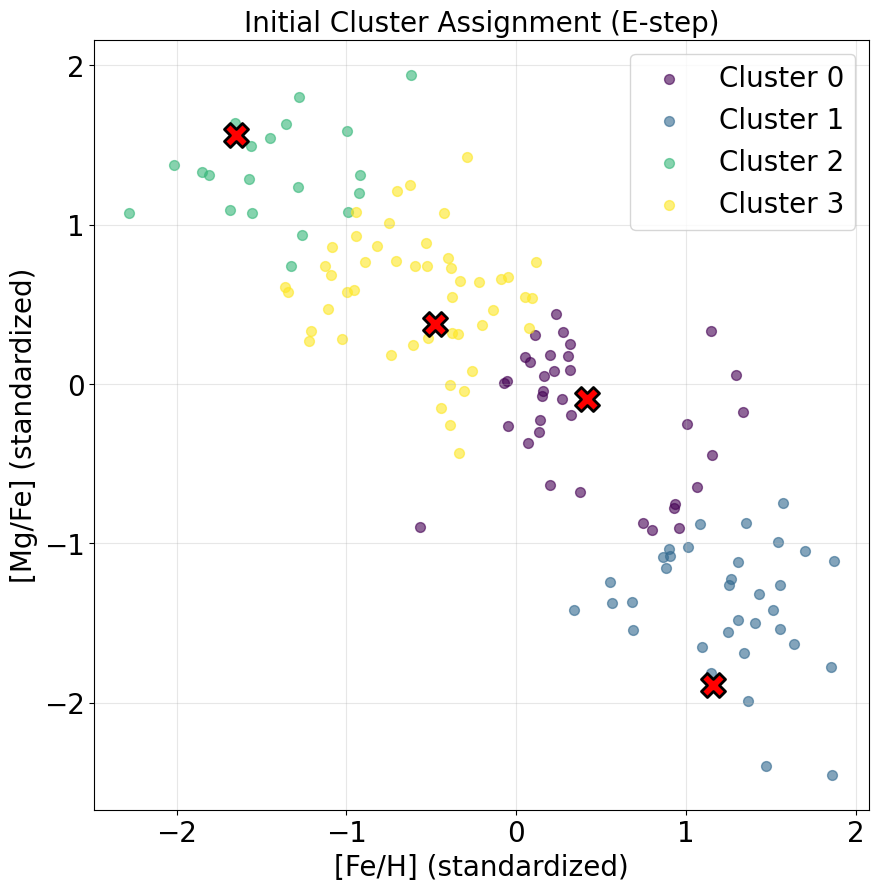

In [6]:
def assign_clusters(X, centroids):
    """
    E-step: Assign each data point to the nearest centroid
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    centroids : array, shape (k, n_features)
        The current centroids
    
    Returns:
    --------
    labels : array, shape (n_samples,)
        The cluster assignments for each data point
    """
    n_samples = X.shape[0]
    k = centroids.shape[0]
    
    # Compute squared Euclidean distances to all centroids
    distances = np.zeros((n_samples, k))
    for i in range(k):
        distances[:, i] = np.sum((X - centroids[i])**2, axis=1)
    
    # Assign to nearest centroid
    labels = np.argmin(distances, axis=1)
    
    return labels

# Apply E-step with K-means++ initialization
labels = assign_clusters(X_std, kmeans_pp_centroids)

# Analyze cluster assignments
unique_labels, counts = np.unique(labels, return_counts=True)
print("Initial cluster assignments:")
for label, count in zip(unique_labels, counts):
    print(f"  Cluster {label}: {count} stars ({100*count/len(X):.1f}%)")

# Visualize the cluster assignments
plt.figure(figsize=(10, 10))

colors = plt.cm.viridis(np.linspace(0, 1, k))
for i in range(k):
    cluster_mask = labels == i
    plt.scatter(X_std[cluster_mask, 0], X_std[cluster_mask, 1], 
               c=[colors[i]], alpha=0.6, s=50, label=f'Cluster {i}')

# Plot centroids
for i in range(k):
    plt.scatter(kmeans_pp_centroids[i, 0], kmeans_pp_centroids[i, 1], 
               c='red', s=300, marker='X', edgecolor='black', linewidth=2)

plt.xlabel('[Fe/H] (standardized)')
plt.ylabel('[Mg/Fe] (standardized)')
plt.title('Initial Cluster Assignment (E-step)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Updating Centroids: The M-step

Following the cluster assignments, the M-step updates each centroid to minimize the sum of squared distances within its cluster. The optimal position proves to be simply the arithmetic mean of all points assigned to that cluster—hence the name "K-means."

This update rule has an intuitive interpretation: each centroid moves to the center of mass of its assigned points. Mathematically, for cluster $k$ with assigned points $\mathcal{C}_k$, the new centroid becomes:

$$\boldsymbol{\mu}_k^{new} = \frac{1}{|\mathcal{C}_k|} \sum_{\mathbf{x}_n \in \mathcal{C}_k} \mathbf{x}_n$$

The M-step embodies a fundamental principle in clustering: good cluster representatives should minimize the average distance to their members. By iteratively refining these representatives, K-means progressively discovers structure in the data, with centroids migrating toward regions of high density.

Let's implement the M-step and visualize how centroids move from their initial positions:


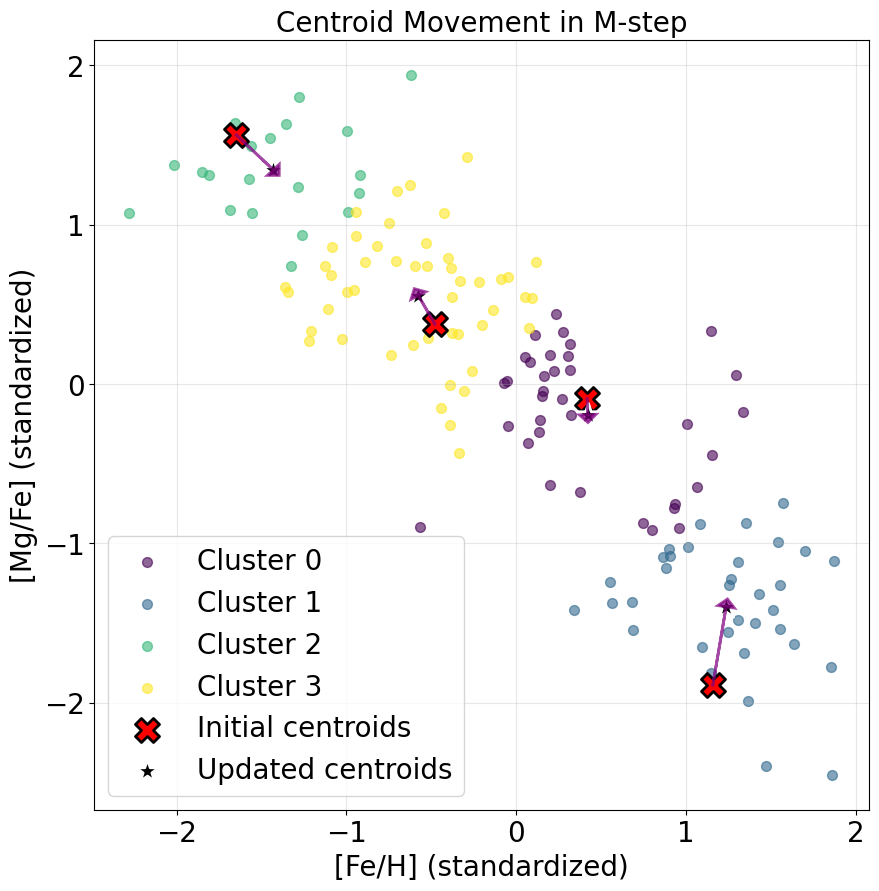

Centroid movements:
  Centroid 0: moved 0.101 units
  Centroid 1: moved 0.498 units
  Centroid 2: moved 0.309 units
  Centroid 3: moved 0.204 units


In [7]:
def update_centroids(X, labels, k):
    """
    M-step: Update centroids based on current cluster assignments
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    labels : array, shape (n_samples,)
        The cluster assignments
    k : int
        The number of clusters
    
    Returns:
    --------
    centroids : array, shape (k, n_features)
        The updated centroids
    """
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))
    
    for i in range(k):
        # Select points in this cluster
        cluster_mask = labels == i
        cluster_points = X[cluster_mask]
        
        # Update centroid to mean of assigned points
        if len(cluster_points) > 0:
            centroids[i] = np.mean(cluster_points, axis=0)
        else:
            # Handle empty clusters by keeping previous position
            # This is rare with good initialization
            print(f"Warning: Cluster {i} is empty")
    
    return centroids

# Apply M-step
updated_centroids = update_centroids(X_std, labels, k=k)

# Visualize centroid movement
plt.figure(figsize=(10, 10))

# Plot data points colored by cluster
for i in range(k):
    cluster_mask = labels == i
    plt.scatter(X_std[cluster_mask, 0], X_std[cluster_mask, 1], 
               c=[colors[i]], alpha=0.6, s=50, label=f'Cluster {i}')

# Plot initial centroids
plt.scatter(kmeans_pp_centroids[:, 0], kmeans_pp_centroids[:, 1], 
           c='red', s=300, marker='X', edgecolor='black', linewidth=2, 
           label='Initial centroids')

# Plot updated centroids
plt.scatter(updated_centroids[:, 0], updated_centroids[:, 1], 
           c='black', s=300, marker='*', edgecolor='white', linewidth=2, 
           label='Updated centroids')

# Draw arrows showing movement
for i in range(k):
    plt.arrow(kmeans_pp_centroids[i, 0], kmeans_pp_centroids[i, 1],
             updated_centroids[i, 0] - kmeans_pp_centroids[i, 0],
             updated_centroids[i, 1] - kmeans_pp_centroids[i, 1],
             head_width=0.1, head_length=0.05, fc='purple', ec='purple', 
             alpha=0.7, linewidth=2)

plt.xlabel('[Fe/H] (standardized)')
plt.ylabel('[Mg/Fe] (standardized)')
plt.title('Centroid Movement in M-step')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Report centroid movements
print("Centroid movements:")
for i in range(k):
    distance = np.linalg.norm(updated_centroids[i] - kmeans_pp_centroids[i])
    print(f"  Centroid {i}: moved {distance:.3f} units")

## The Complete K-means Algorithm

We now combine the E-step and M-step into the complete K-means algorithm, iterating between cluster assignment and centroid update until convergence. The algorithm monitors convergence through two metrics:

1. **Centroid Movement**: The algorithm converges when centroids stop moving significantly between iterations
2. **Inertia**: The total within-cluster sum of squares, which decreases monotonically and plateaus at convergence

The inertia serves as our objective function:

$$J = \sum_{k=1}^K \sum_{\mathbf{x}_n \in \mathcal{C}_k} ||\mathbf{x}_n - \boldsymbol{\mu}_k||^2$$

Lower inertia indicates tighter clusters, though the absolute value depends on the number of clusters and data scale. By tracking inertia across iterations, we can visualize the algorithm's progress and verify proper convergence.

Let's implement the full algorithm with convergence monitoring:


In [8]:
def kmeans(X, k, max_iter=100, tol=1e-4, init_method='random', random_state=None):
    """
    K-means clustering algorithm
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of clusters
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance (change in centroids)
    init_method : str, 'random' or 'kmeans++'
        Method for initializing centroids
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    centroids : array, shape (k, n_features)
        The final centroids
    labels : array, shape (n_samples,)
        The final cluster assignments
    inertia : float
        Sum of squared distances to closest centroid
    n_iter : int
        Number of iterations run
    history : dict
        Dictionary containing convergence history
    """
    # Initialize centroids
    if init_method == 'random':
        centroids = init_random(X, k, random_state)
    elif init_method == 'kmeans++':
        centroids = init_kmeans_plus_plus(X, k, random_state)
    else:
        raise ValueError("init_method must be 'random' or 'kmeans++'")
    
    # Initialize history tracking
    history = {
        'centroids': [centroids.copy()],
        'inertia': []
    }
    
    # Iterative optimization
    for iteration in range(max_iter):
        # E-step: Assign clusters
        labels = assign_clusters(X, centroids)
        
        # Calculate inertia
        inertia = 0
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - centroids[j])**2)
        history['inertia'].append(inertia)
        
        # M-step: Update centroids
        new_centroids = update_centroids(X, labels, k)
        
        # Check convergence
        centroid_shift = np.sqrt(np.sum((new_centroids - centroids)**2))
        
        # Update centroids
        centroids = new_centroids
        history['centroids'].append(centroids.copy())
        
        if centroid_shift < tol:
            print(f"K-means converged after {iteration + 1} iterations")
            break
    
    # Final assignment and inertia
    labels = assign_clusters(X, centroids)
    inertia = 0
    for j in range(k):
        cluster_points = X[labels == j]
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroids[j])**2)
    
    return centroids, labels, inertia, iteration + 1, history

Running K-means with random initialization...
K-means converged after 10 iterations

Running K-means with K-means++ initialization...
K-means converged after 5 iterations

Random initialization: Inertia = 38.60
K-means++ initialization: Inertia = 38.60


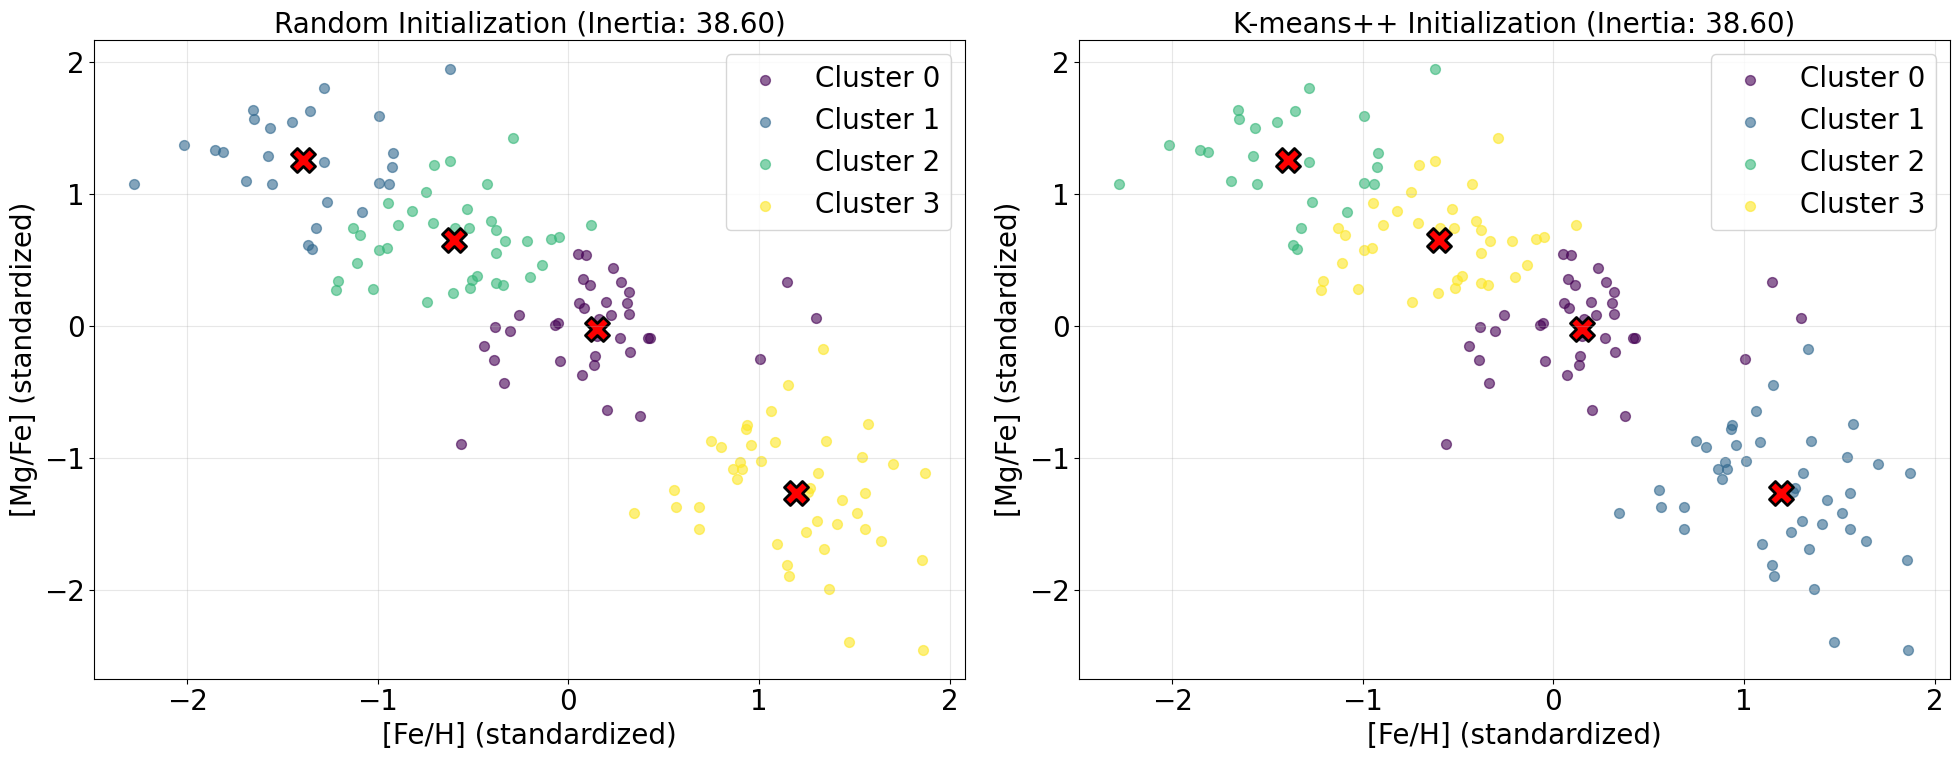

In [9]:
# Run K-means with both initialization methods
print("Running K-means with random initialization...")
random_centroids, random_labels, random_inertia, random_iters, random_history = kmeans(
    X_std, k=4, init_method='random', random_state=42)

print("\nRunning K-means with K-means++ initialization...")
kmpp_centroids, kmpp_labels, kmpp_inertia, kmpp_iters, kmpp_history = kmeans(
    X_std, k=4, init_method='kmeans++', random_state=42)

print(f"\nRandom initialization: Inertia = {random_inertia:.2f}")
print(f"K-means++ initialization: Inertia = {kmpp_inertia:.2f}")

# Visualize final clustering results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Random initialization results
for i in range(4):
    cluster_mask = random_labels == i
    ax1.scatter(X_std[cluster_mask, 0], X_std[cluster_mask, 1], 
               c=[colors[i]], alpha=0.6, s=50, label=f'Cluster {i}')
ax1.scatter(random_centroids[:, 0], random_centroids[:, 1], 
           c='red', s=300, marker='X', edgecolor='black', linewidth=2)
ax1.set_xlabel('[Fe/H] (standardized)')
ax1.set_ylabel('[Mg/Fe] (standardized)')
ax1.set_title(f'Random Initialization (Inertia: {random_inertia:.2f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# K-means++ initialization results
for i in range(4):
    cluster_mask = kmpp_labels == i
    ax2.scatter(X_std[cluster_mask, 0], X_std[cluster_mask, 1], 
               c=[colors[i]], alpha=0.6, s=50, label=f'Cluster {i}')
ax2.scatter(kmpp_centroids[:, 0], kmpp_centroids[:, 1], 
           c='red', s=300, marker='X', edgecolor='black', linewidth=2)
ax2.set_xlabel('[Fe/H] (standardized)')
ax2.set_ylabel('[Mg/Fe] (standardized)')
ax2.set_title(f'K-means++ Initialization (Inertia: {kmpp_inertia:.2f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

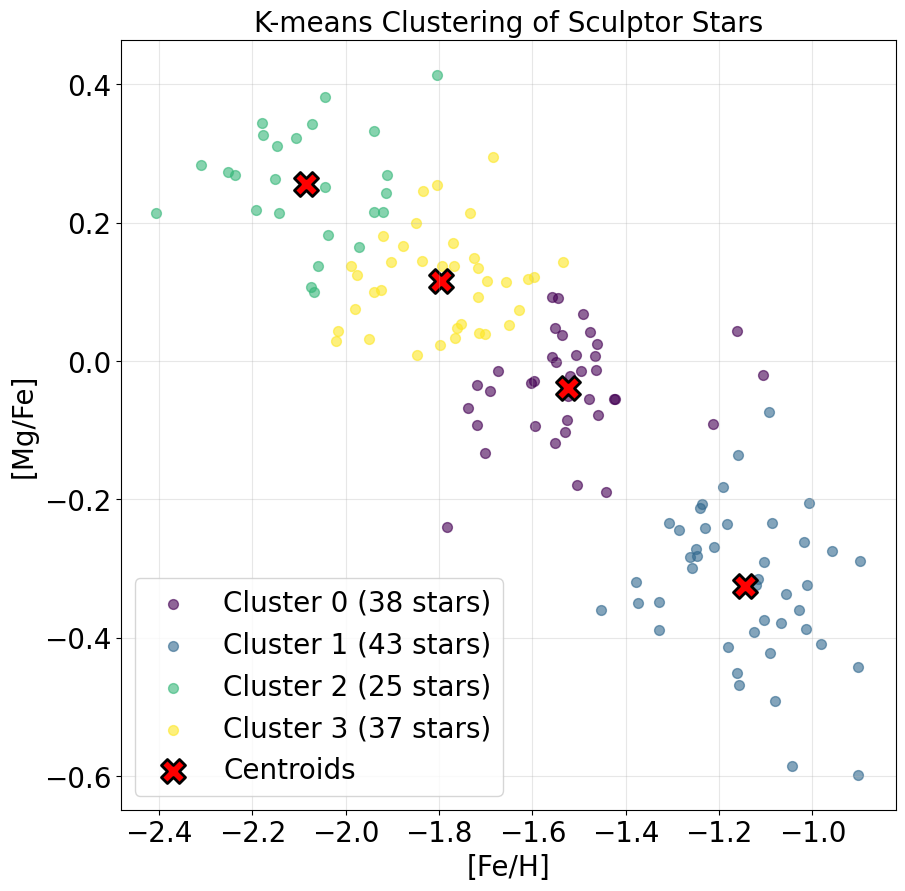

Cluster properties in original abundance space:

Cluster 0:
  Centroid: [Fe/H] = -1.523, [Mg/Fe] = -0.039
  Size: 38 stars
  [Fe/H] range: [-1.783, -1.106]
  [Mg/Fe] range: [-0.240, 0.093]

Cluster 1:
  Centroid: [Fe/H] = -1.145, [Mg/Fe] = -0.325
  Size: 43 stars
  [Fe/H] range: [-1.453, -0.897]
  [Mg/Fe] range: [-0.598, -0.074]

Cluster 2:
  Centroid: [Fe/H] = -2.084, [Mg/Fe] = 0.256
  Size: 25 stars
  [Fe/H] range: [-2.407, -1.803]
  [Mg/Fe] range: [0.101, 0.414]

Cluster 3:
  Centroid: [Fe/H] = -1.796, [Mg/Fe] = 0.116
  Size: 37 stars
  [Fe/H] range: [-2.021, -1.535]
  [Mg/Fe] range: [0.009, 0.295]


In [10]:
# Visualize results in original feature space for astrophysical interpretation
plt.figure(figsize=(10, 10))

# Convert standardized centroids back to original scale
centroids_orig = kmpp_centroids * std_X + mean_X

# Plot clusters in original space
for i in range(4):
    cluster_mask = kmpp_labels == i
    cluster_points = X[cluster_mask]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               c=[colors[i]], alpha=0.6, s=50, label=f'Cluster {i} ({np.sum(cluster_mask)} stars)')

# Plot centroids
plt.scatter(centroids_orig[:, 0], centroids_orig[:, 1], 
           c='red', s=300, marker='X', edgecolor='black', linewidth=2, label='Centroids')

plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.title('K-means Clustering of Sculptor Stars')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Report cluster properties
print("Cluster properties in original abundance space:")
for i in range(4):
    cluster_mask = kmpp_labels == i
    cluster_fe_h = X[cluster_mask, 0]
    cluster_mg_fe = X[cluster_mask, 1]
    print(f"\nCluster {i}:")
    print(f"  Centroid: [Fe/H] = {centroids_orig[i, 0]:.3f}, [Mg/Fe] = {centroids_orig[i, 1]:.3f}")
    print(f"  Size: {np.sum(cluster_mask)} stars")
    print(f"  [Fe/H] range: [{np.min(cluster_fe_h):.3f}, {np.max(cluster_fe_h):.3f}]")
    print(f"  [Mg/Fe] range: [{np.min(cluster_mg_fe):.3f}, {np.max(cluster_mg_fe):.3f}]")

## Visualizing K-means Convergence

The iterative nature of K-means provides insight into how the algorithm discovers structure in our data. By tracking the movement of centroids and the evolution of inertia across iterations, we can understand both the convergence behavior and the stability of our solution.

The convergence visualization serves multiple purposes:
1. **Algorithm validation**: Confirming that inertia decreases monotonically
2. **Initialization impact**: Comparing convergence speed between random and K-means++ initialization
3. **Solution stability**: Assessing whether the algorithm settles quickly or continues refining for many iterations

For our stellar abundance data, we expect rapid initial progress as centroids move from their starting positions toward regions of high stellar density, followed by fine-tuning as the algorithm approaches a local minimum. The comparison between initialization methods should reveal K-means++'s advantage in both convergence speed and solution quality.

Convergence with random initialization:


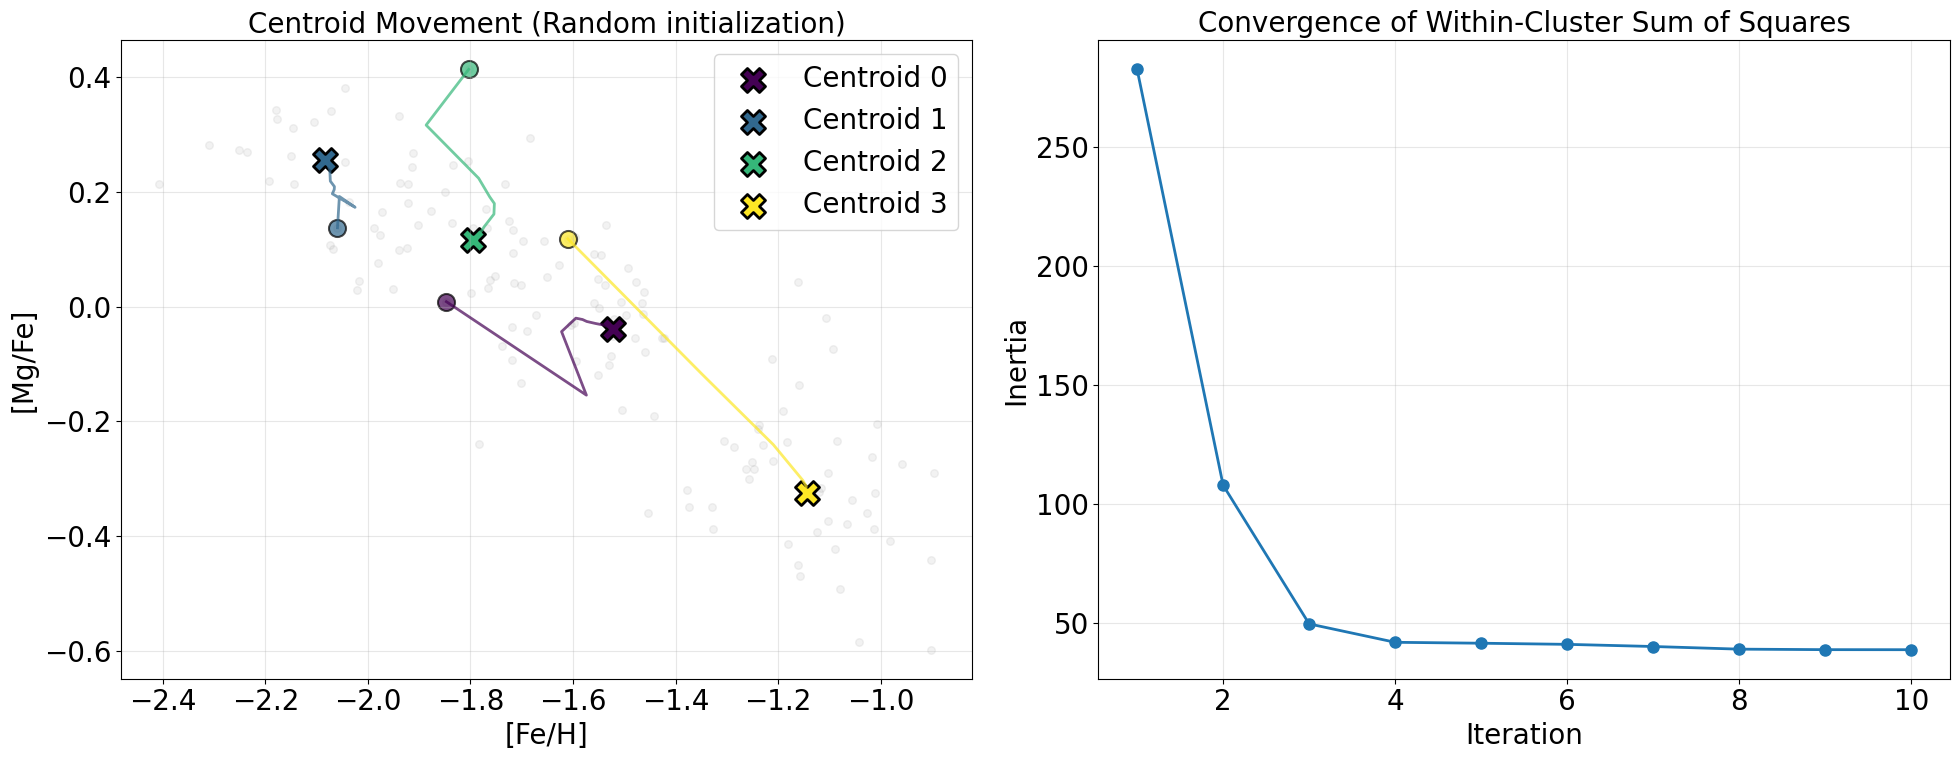


Convergence with K-means++ initialization:


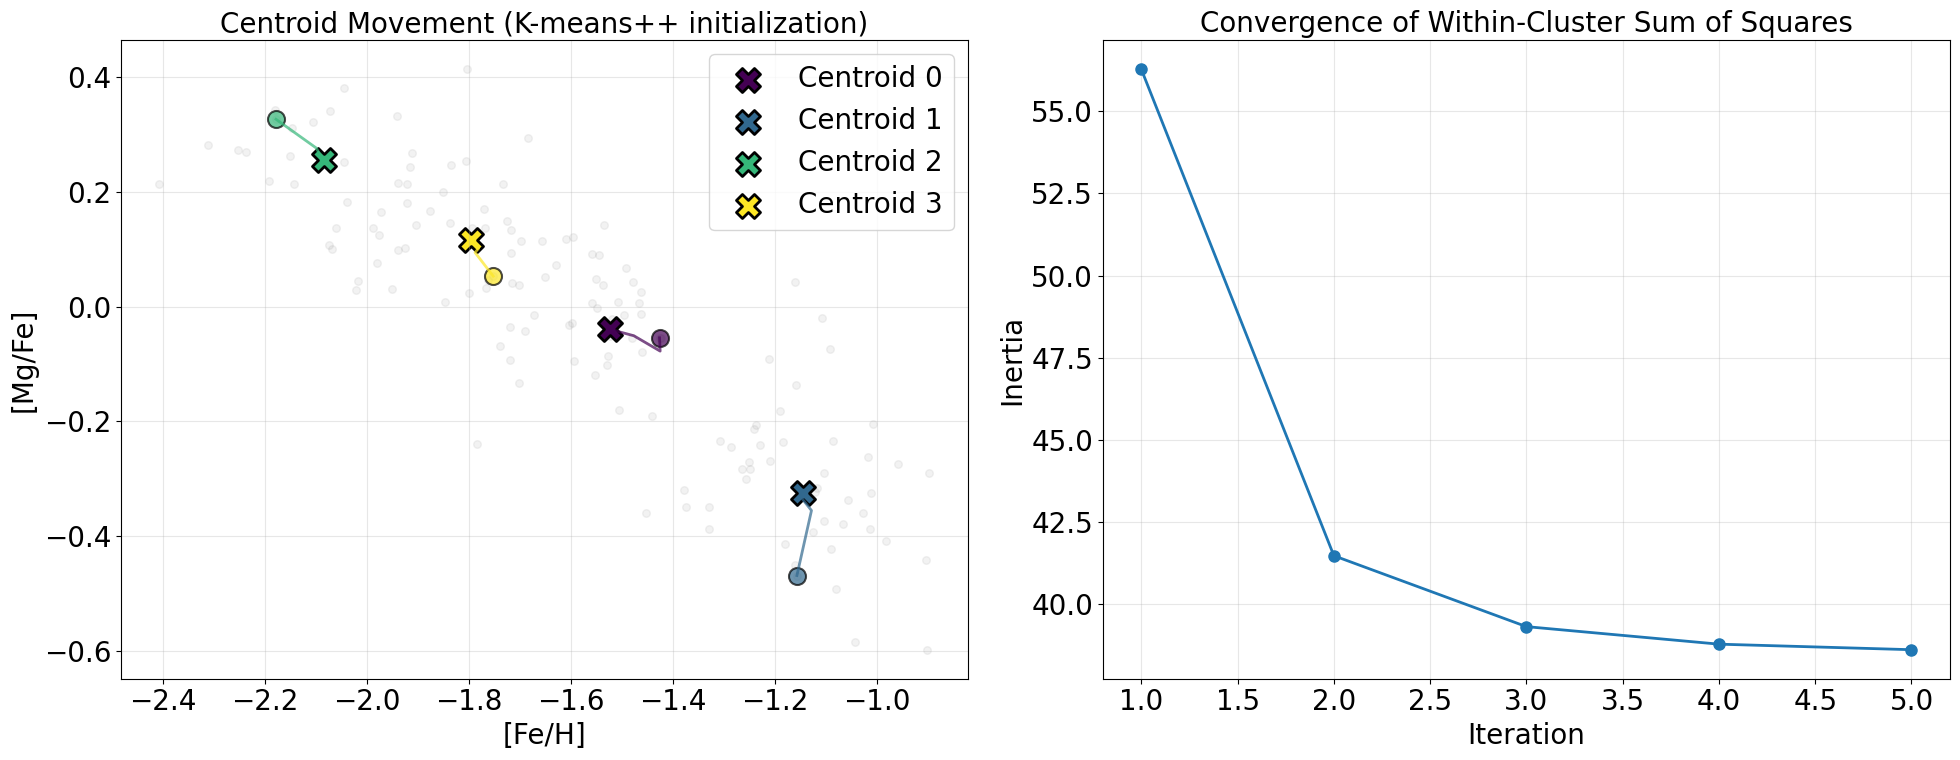

In [11]:
def visualize_kmeans_convergence(X, history, init_method='random'):
    """Visualize K-means convergence: centroid paths and inertia evolution"""
    centroids_history = history['centroids']
    inertia_history = history['inertia']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Left plot: Centroid movement paths
    # Plot data points
    ax1.scatter(X[:, 0], X[:, 1], alpha=0.1, s=30, c='gray')
    
    # Plot centroid paths
    colors = plt.cm.viridis(np.linspace(0, 1, 4))
    for i in range(4):
        # Extract path for centroid i across iterations
        centroid_path = np.array([c[i] for c in centroids_history])
        # Convert to original scale
        centroid_path_orig = centroid_path * std_X + mean_X
        
        # Plot path
        ax1.plot(centroid_path_orig[:, 0], centroid_path_orig[:, 1], 
                '-', color=colors[i], alpha=0.7, linewidth=2)
        
        # Mark start and end points
        ax1.scatter(centroid_path_orig[0, 0], centroid_path_orig[0, 1], 
                   c=[colors[i]], s=150, marker='o', edgecolor='black', 
                   linewidth=1.5, alpha=0.7)
        ax1.scatter(centroid_path_orig[-1, 0], centroid_path_orig[-1, 1], 
                   c=[colors[i]], s=300, marker='X', edgecolor='black', 
                   linewidth=2, label=f'Centroid {i}')
    
    ax1.set_xlabel('[Fe/H]')
    ax1.set_ylabel('[Mg/Fe]')
    ax1.set_title(f'Centroid Movement ({init_method} initialization)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Inertia convergence
    ax2.plot(range(1, len(inertia_history) + 1), inertia_history, 
            'o-', linewidth=2, markersize=8)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Inertia')
    ax2.set_title('Convergence of Within-Cluster Sum of Squares')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize convergence for both initialization methods
print("Convergence with random initialization:")
visualize_kmeans_convergence(X, random_history, 'Random')

print("\nConvergence with K-means++ initialization:")
visualize_kmeans_convergence(X, kmpp_history, 'K-means++')

## Selecting the Optimal Number of Clusters

A fundamental challenge in clustering analysis is determining the appropriate number of clusters. K-means requires us to specify K in advance, but how do we know the true number of stellar populations in Sculptor? The elbow method provides a heuristic approach by examining how the within-cluster sum of squares (inertia) decreases as we increase K.

The intuition is straightforward: adding more clusters always reduces inertia—in the extreme case of K=N, each point forms its own cluster with zero inertia. However, if the data contains natural groupings, we expect a point of diminishing returns where additional clusters provide minimal benefit. This manifests as an "elbow" in the inertia curve—a transition from rapid improvement to gradual decline.

For our stellar populations, the elbow location would suggest the number of distinct chemical enrichment episodes. Beyond this point, additional clusters likely split genuine populations rather than revealing new structure. While the elbow method provides guidance, the ultimate choice requires combining statistical evidence with astrophysical interpretation.

Let's compute inertia across a range of K values to identify potential structure in our chemical abundance data:

Computing K-means with k=2... K-means converged after 4 iterations
Inertia: 93.40
Computing K-means with k=3... K-means converged after 6 iterations
Inertia: 47.26
Computing K-means with k=4... K-means converged after 5 iterations
Inertia: 38.60
Computing K-means with k=5... K-means converged after 9 iterations
Inertia: 30.99
Computing K-means with k=6... K-means converged after 10 iterations
Inertia: 26.57
Computing K-means with k=7... K-means converged after 10 iterations
Inertia: 23.18
Computing K-means with k=8... K-means converged after 11 iterations
Inertia: 20.93
Computing K-means with k=9... K-means converged after 18 iterations
Inertia: 18.04


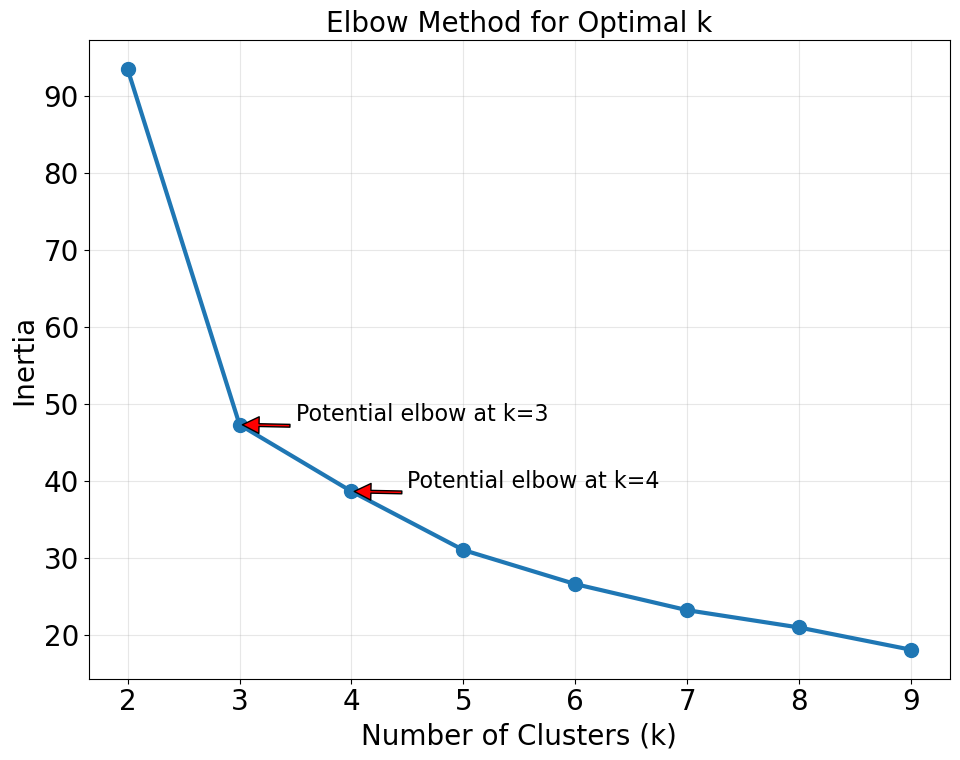


Percentage decrease in inertia:
  k=2 to k=3: 49.4%
  k=3 to k=4: 18.3%
  k=4 to k=5: 19.7%
  k=5 to k=6: 14.3%
  k=6 to k=7: 12.8%
  k=7 to k=8: 9.7%
  k=8 to k=9: 13.8%


In [12]:
def inertia_analysis(X, k_range=range(2, 10), init_method='kmeans++', random_state=42):
    """
    Compute K-means inertia for different values of k
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k_range : iterable
        Range of k values to try
    init_method : str
        Initialization method
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    inertias : list
        Inertia for each value of k
    """
    inertias = []
    
    for k in k_range:
        print(f"Computing K-means with k={k}...", end=' ')
        _, _, inertia, _, _ = kmeans(X, k, init_method=init_method, random_state=random_state)
        inertias.append(inertia)
        print(f"Inertia: {inertia:.2f}")
    
    return inertias

# Analyze inertia for different numbers of clusters
k_range = range(2, 10)
inertias = inertia_analysis(X_std, k_range, init_method='kmeans++')

# Plot the elbow curve
plt.figure(figsize=(10, 8))
plt.plot(k_range, inertias, 'o-', linewidth=3, markersize=10)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)

# Highlight potential elbow points
for k_elbow in [3, 4]:
    idx = k_elbow - 2  # Adjust for 0-based indexing starting at k=2
    plt.annotate(f'Potential elbow at k={k_elbow}', 
                xy=(k_elbow, inertias[idx]), 
                xytext=(k_elbow + 0.5, inertias[idx] + 0.5),
                arrowprops=dict(facecolor='red', shrink=0.05, width=2),
                fontsize=16)

plt.tight_layout()
plt.show()

# Calculate percentage decrease in inertia
print("\nPercentage decrease in inertia:")
for i in range(1, len(inertias)):
    decrease = 100 * (inertias[i-1] - inertias[i]) / inertias[i-1]
    print(f"  k={i+1} to k={i+2}: {decrease:.1f}%")

## From K-means to Gaussian Mixture Models

The elbow analysis reveals an ambiguous picture—potential elbows at both k=3 and k=4, with no dramatic transition in the inertia curve. This ambiguity highlights a fundamental limitation of K-means: its rigid assumptions about cluster structure. K-means implicitly assumes:

1. **Spherical clusters**: Equal variance in all directions
2. **Equal cluster sizes**: Similar numbers of points in each cluster  
3. **Hard assignments**: Each point belongs to exactly one cluster
4. **Euclidean geometry**: Clusters defined by distance to centroids

These assumptions may poorly match the reality of stellar populations. Chemical evolution creates populations with different sizes (varying star formation efficiencies), different shapes (anisotropic dispersion in abundance space), and potentially overlapping boundaries (stars forming during transition periods).

Gaussian Mixture Models (GMMs) address these limitations through a probabilistic framework. Rather than forcing hard cluster assignments, GMMs model the data as arising from a mixture of Gaussian distributions, each potentially having different means, covariances, and weights. This flexibility allows GMMs to:

- Capture elliptical clusters with arbitrary orientations
- Model clusters of vastly different sizes and densities
- Provide probabilistic assignments that quantify uncertainty
- Better represent the continuous nature of chemical evolution

The shift from K-means to GMMs represents a philosophical transition from partitioning to modeling. While K-means asks "How can we divide these stars into groups?", GMMs ask "What mixture of populations could have produced this distribution?" This generative perspective often provides deeper insights into the underlying astrophysical processes.

Let's implement GMMs from scratch to understand how this probabilistic approach reveals structure in our stellar abundance data.

## Gaussian Mixture Models: A Probabilistic Approach

Gaussian Mixture Models represent each data point as being generated from one of K multivariate Gaussian distributions. The probability density function takes the form:

$$p(\mathbf{x}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$$

where:
- $\pi_k$ represents the mixing weight of component $k$ (with $\sum_{k=1}^K \pi_k = 1$)
- $\boldsymbol{\mu}_k$ is the mean vector of component $k$
- $\boldsymbol{\Sigma}_k$ is the covariance matrix of component $k$
- $\mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ denotes the multivariate Gaussian distribution

Each Gaussian component can be thought of as representing a distinct stellar population, with its own characteristic location in abundance space (mean), spread and correlation structure (covariance), and relative contribution to the total population (weight).

The parameters are estimated using the Expectation-Maximization (EM) algorithm, which iteratively:
- **E-step**: Computes the probability that each star belongs to each population
- **M-step**: Updates the population parameters based on these probabilistic assignments

This soft assignment contrasts sharply with K-means' hard partitioning, acknowledging that stars near population boundaries might plausibly belong to either group—a more realistic model for continuous chemical evolution processes.

Let's begin by implementing the multivariate Gaussian probability density function:

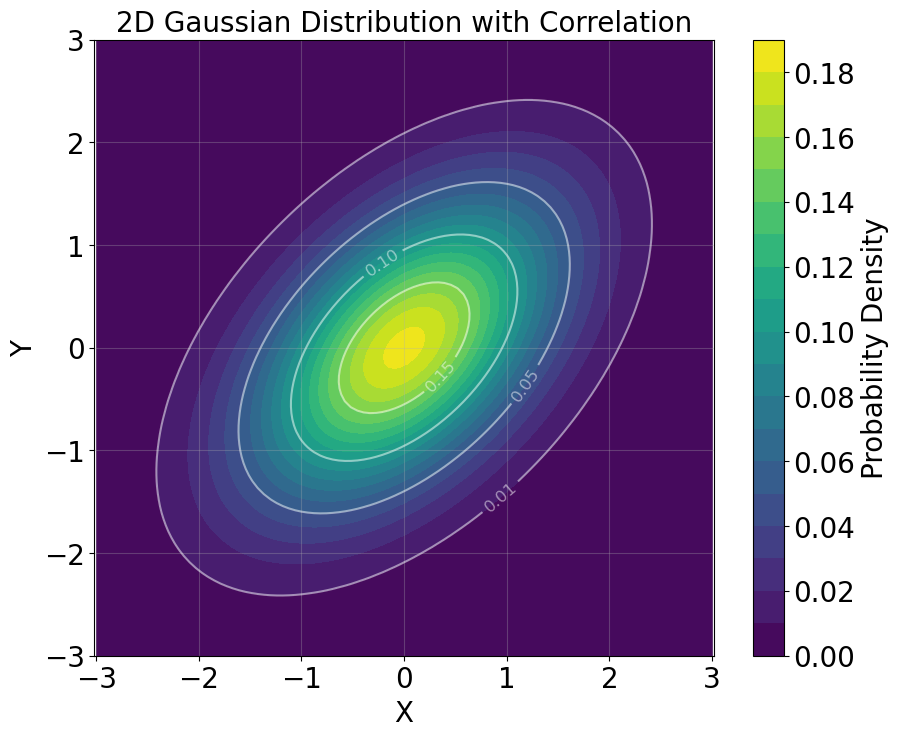

In [13]:
def multivariate_normal_pdf(X, mu, sigma):
    """
    Compute the PDF of a multivariate normal distribution
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The data points
    mu : array, shape (n_features,)
        The mean vector
    sigma : array, shape (n_features, n_features)
        The covariance matrix
    
    Returns:
    --------
    pdf_values : array, shape (n_samples,)
        The PDF values for each data point
    """
    n_features = X.shape[1]
    
    # Add regularization to ensure numerical stability
    sigma_reg = sigma + np.eye(n_features) * 1e-6
    
    # Use scipy's implementation for numerical stability
    return multivariate_normal.pdf(X, mean=mu, cov=sigma_reg)

# Visualize a 2D Gaussian distribution
# Create a grid for visualization
x_grid = np.linspace(-3, 3, 100)
y_grid = np.linspace(-3, 3, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
pos = np.dstack((X_grid, Y_grid))

# Define a test Gaussian
test_mu = np.array([0, 0])
test_sigma = np.array([[1.0, 0.5], [0.5, 1.0]])
rv = multivariate_normal(mean=test_mu, cov=test_sigma)

# Plot the 2D Gaussian
plt.figure(figsize=(10, 8))
plt.contourf(X_grid, Y_grid, rv.pdf(pos), levels=20, cmap='viridis')
plt.colorbar(label='Probability Density')

# Add contour lines at specific probability levels
contour_levels = [0.01, 0.05, 0.1, 0.15]
CS = plt.contour(X_grid, Y_grid, rv.pdf(pos), levels=contour_levels, colors='white', alpha=0.5)
plt.clabel(CS, inline=True, fontsize=12)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Gaussian Distribution with Correlation')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## Initializing Gaussian Mixture Models

Proper initialization is crucial for GMM convergence, just as with K-means. A poor initialization can lead to degenerate solutions where components collapse to single points or fail to separate meaningfully. We'll use a strategy that leverages K-means to provide a sensible starting point:

1. **Run K-means** to obtain initial cluster assignments
2. **Set mixture weights** proportional to cluster sizes
3. **Initialize means** at the K-means centroids
4. **Compute covariances** from the scatter of points within each cluster

This initialization strategy has several advantages:
- K-means provides well-separated initial components
- Covariances capture the actual spread of data in each region
- Weights reflect the relative population sizes

The covariance initialization is particularly important. Unlike K-means, which implicitly assumes spherical clusters, GMM can model elliptical clusters with arbitrary orientations. By initializing covariances from the data, we immediately capture any anisotropic structure in our stellar populations—perhaps reflecting different velocity dispersions or formation mechanisms.

Let's implement this initialization strategy:

In [14]:
def initialize_gmm(X, k, init_method='kmeans++', random_state=None):
    """
    Initialize GMM parameters using K-means clustering
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of components
    init_method : str
        Initialization method for K-means
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    weights : array, shape (k,)
        Initial mixture weights
    means : array, shape (k, n_features)
        Initial component means
    covariances : array, shape (k, n_features, n_features)
        Initial component covariances
    """
    n_samples, n_features = X.shape
    
    # Run K-means for initialization
    centroids, labels, _, _, _ = kmeans(X, k, init_method=init_method, random_state=random_state)
    
    # Initialize arrays
    weights = np.zeros(k)
    means = centroids.copy()
    covariances = np.zeros((k, n_features, n_features))
    
    # Compute initial parameters for each component
    for i in range(k):
        cluster_mask = labels == i
        cluster_points = X[cluster_mask]
        n_cluster = len(cluster_points)
        
        # Set weight proportional to cluster size
        weights[i] = n_cluster / n_samples
        
        # Compute covariance if enough points
        if n_cluster > n_features:
            covariances[i] = np.cov(cluster_points, rowvar=False)
        else:
            # Use identity matrix for small clusters
            covariances[i] = np.eye(n_features)
        
        # Add regularization for numerical stability
        covariances[i] += np.eye(n_features) * 1e-6
    
    return weights, means, covariances

# Initialize GMM with k=4 components
weights, means, covariances = initialize_gmm(X_std, k=4, init_method='kmeans++', random_state=42)

print("Initial GMM parameters:")
print(f"Mixture weights: {weights}")
print(f"Sum of weights: {np.sum(weights):.6f}")
for i in range(4):
    print(f"\nComponent {i}:")
    print(f"  Weight: {weights[i]:.3f}")
    print(f"  Mean: {means[i]}")
    print(f"  Covariance shape: {covariances[i].shape}")
    print(f"  Covariance determinant: {np.linalg.det(covariances[i]):.6f}")

K-means converged after 5 iterations
Initial GMM parameters:
Mixture weights: [0.26573427 0.3006993  0.17482517 0.25874126]
Sum of weights: 1.000000

Component 0:
  Weight: 0.266
  Mean: [ 0.15153266 -0.02505666]
  Covariance shape: (2, 2)
  Covariance determinant: 0.014873

Component 1:
  Weight: 0.301
  Mean: [ 1.19112794 -1.26529716]
  Covariance shape: (2, 2)
  Covariance determinant: 0.027819

Component 2:
  Weight: 0.175
  Mean: [-1.39187352  1.25491809]
  Covariance shape: (2, 2)
  Covariance determinant: 0.018442

Component 3:
  Weight: 0.259
  Mean: [-0.59945688  0.64829672]
  Covariance shape: (2, 2)
  Covariance determinant: 0.011071


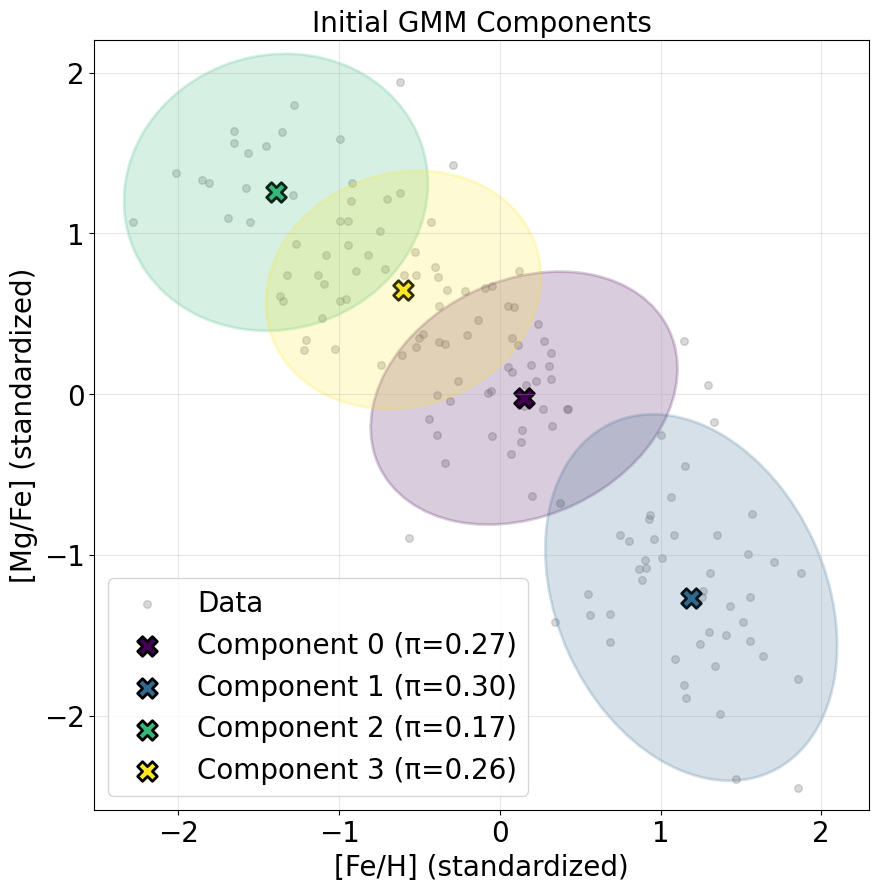

In [15]:
# Visualize the initialized GMM components
plt.figure(figsize=(10, 10))

# Plot data points
plt.scatter(X_std[:, 0], X_std[:, 1], s=30, alpha=0.3, color='gray', label='Data')

# Plot each Gaussian component
colors = plt.cm.viridis(np.linspace(0, 1, 4))
for i in range(4):
    # Plot mean
    plt.scatter(means[i, 0], means[i, 1], s=200, marker='X', 
                color=colors[i], edgecolor='black', linewidth=2, 
                label=f'Component {i} (π={weights[i]:.2f})')
    
    # Plot covariance ellipse (95% confidence)
    # Eigendecomposition for ellipse parameters
    eigenvalues, eigenvectors = np.linalg.eigh(covariances[i])
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # Ellipse angle and dimensions
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * 2.447 * np.sqrt(eigenvalues)  # 95% confidence
    
    # Create and add ellipse
    ellipse = patches.Ellipse(xy=means[i], width=width, height=height, 
                             angle=angle, facecolor=colors[i], alpha=0.2, 
                             edgecolor=colors[i], linewidth=2)
    plt.gca().add_patch(ellipse)

plt.xlabel('[Fe/H] (standardized)')
plt.ylabel('[Mg/Fe] (standardized)')
plt.title('Initial GMM Components')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## The E-step: Computing Responsibilities

In the Expectation step of GMM, we compute the posterior probability that each data point belongs to each Gaussian component. These "responsibilities" quantify the likelihood that star $n$ originated from population $k$:

$$\gamma_{nk} = \frac{\pi_k \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}$$

The numerator represents the weighted probability density of observing star $n$ from component $k$, while the denominator ensures the responsibilities sum to 1 across all components for each star.

This soft assignment fundamentally differs from K-means' hard clustering. A star positioned between two populations might have responsibilities of 0.6 and 0.4, reflecting genuine uncertainty about its origin. This probabilistic framework naturally handles:

- **Overlapping populations**: Stars forming during transition periods between bursts
- **Outliers**: Unusual stars receive low responsibilities for all components
- **Uncertainty quantification**: The responsibility distribution itself provides valuable information

During the E-step, we also compute the log-likelihood of observing our data given the current model parameters. This quantity, which we seek to maximize, serves as our objective function and convergence metric:

$$\log \mathcal{L} = \sum_{n=1}^N \log \left( \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \right)$$

Let's implement the E-step and visualize these probabilistic assignments:

In [16]:
def e_step(X, weights, means, covariances):
    """
    E-step: Compute responsibilities (posterior probabilities)
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    weights : array, shape (k,)
        Mixture weights
    means : array, shape (k, n_features)
        Component means
    covariances : array, shape (k, n_features, n_features)
        Component covariances
    
    Returns:
    --------
    responsibilities : array, shape (n_samples, k)
        Responsibility of each component for each sample
    log_likelihood : float
        Log-likelihood of the data under the current model
    """
    n_samples = X.shape[0]
    k = len(weights)
    
    # Compute weighted probabilities for each component
    weighted_probs = np.zeros((n_samples, k))
    
    for i in range(k):
        # Compute probability density for component i
        prob_density = multivariate_normal_pdf(X, means[i], covariances[i])
        # Weight by mixture coefficient
        weighted_probs[:, i] = weights[i] * prob_density
    
    # Total probability for each data point (marginal likelihood)
    total_probs = np.sum(weighted_probs, axis=1)
    
    # Avoid numerical issues with log(0)
    total_probs = np.maximum(total_probs, 1e-300)
    
    # Compute responsibilities (normalize to sum to 1)
    responsibilities = weighted_probs / total_probs.reshape(-1, 1)
    
    # Compute log-likelihood
    log_likelihood = np.sum(np.log(total_probs))
    
    return responsibilities, log_likelihood

# Compute responsibilities with initial parameters
responsibilities, log_likelihood = e_step(X_std, weights, means, covariances)

print(f"Initial log-likelihood: {log_likelihood:.2f}")
print(f"Responsibilities shape: {responsibilities.shape}")
print("\nResponsibilities for first 5 stars:")
print(responsibilities[:5].round(3))
print("\nSum of responsibilities for first 5 stars (should be 1):")
print(responsibilities[:5].sum(axis=1))

Initial log-likelihood: -291.38
Responsibilities shape: (143, 4)

Responsibilities for first 5 stars:
[[0.01  0.    0.005 0.985]
 [0.976 0.    0.    0.023]
 [0.145 0.    0.001 0.854]
 [0.005 0.995 0.    0.   ]
 [0.    0.    1.    0.   ]]

Sum of responsibilities for first 5 stars (should be 1):
[1. 1. 1. 1. 1.]


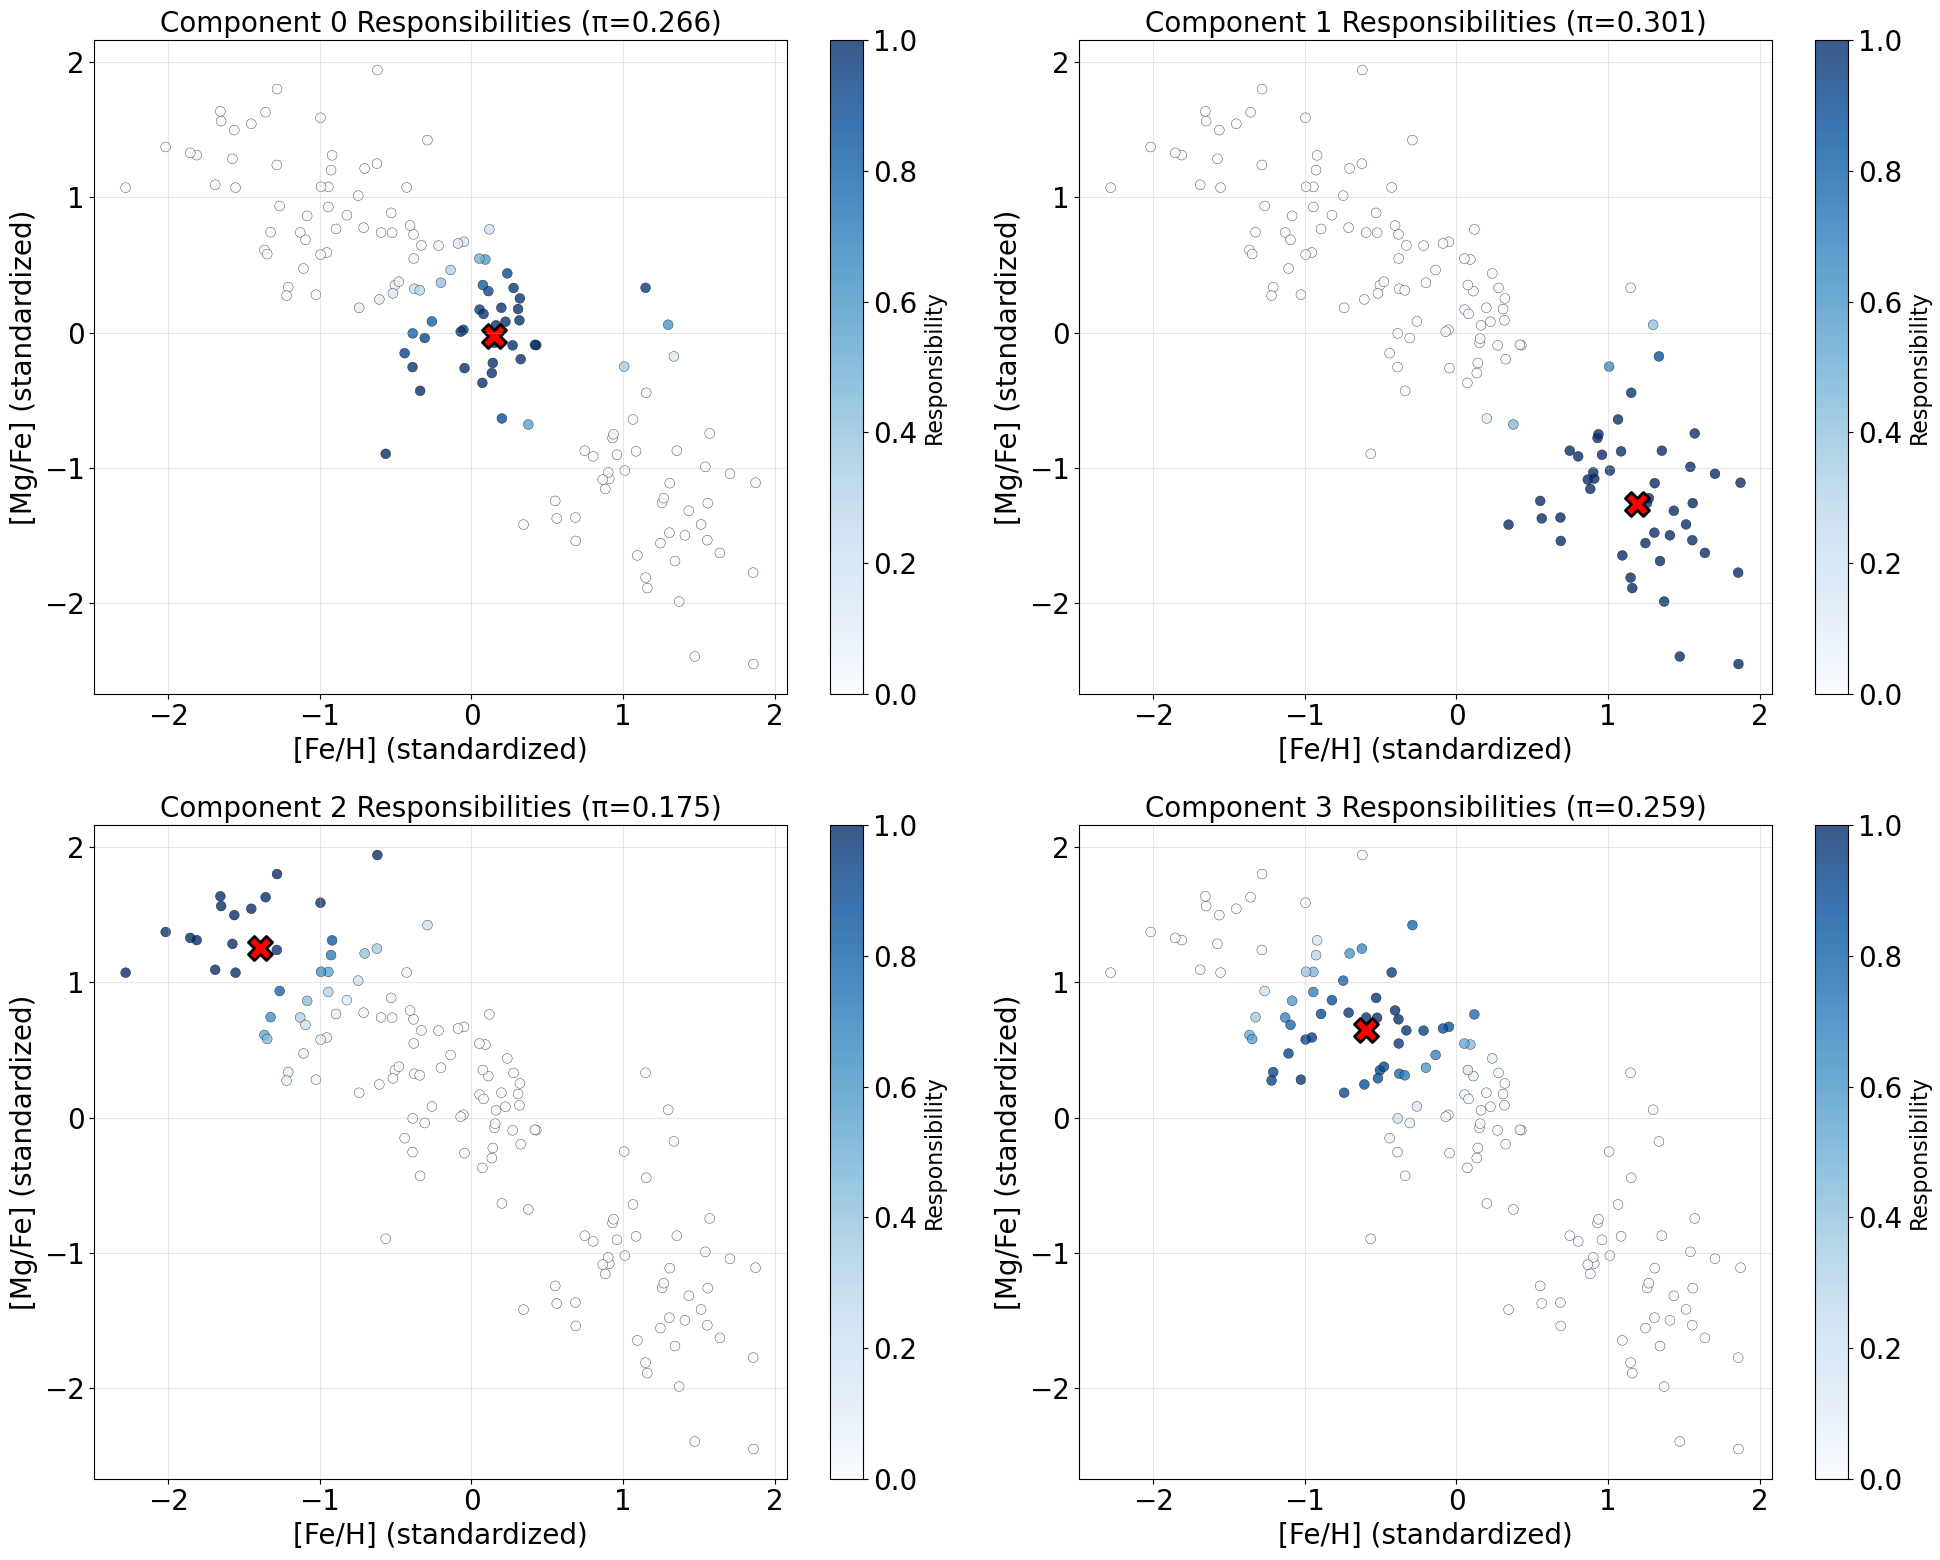

Stars with highest responsibility for each component:

Component 0:
  Max responsibility: 0.999
  Star index: 35
  [Fe/H] = -1.783, [Mg/Fe] = -0.240

Component 1:
  Max responsibility: 1.000
  Star index: 54
  [Fe/H] = -0.902, [Mg/Fe] = -0.598

Component 2:
  Max responsibility: 1.000
  Star index: 141
  [Fe/H] = -2.311, [Mg/Fe] = 0.283

Component 3:
  Max responsibility: 0.986
  Star index: 133
  [Fe/H] = -1.725, [Mg/Fe] = 0.149


In [17]:
# Visualize responsibilities as soft assignments
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

# Plot responsibilities for each component
for i in range(4):
    ax = axes[i]
    
    # Create scatter plot colored by responsibility
    scatter = ax.scatter(X_std[:, 0], X_std[:, 1], 
                        c=responsibilities[:, i], cmap='Blues', 
                        s=50, alpha=0.8, edgecolor='black', linewidth=0.3,
                        vmin=0, vmax=1)
    
    # Add component mean
    ax.scatter(means[i, 0], means[i, 1], s=300, marker='X', 
              color='red', edgecolor='black', linewidth=2)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Responsibility', fontsize=16)
    
    ax.set_xlabel('[Fe/H] (standardized)')
    ax.set_ylabel('[Mg/Fe] (standardized)')
    ax.set_title(f'Component {i} Responsibilities (π={weights[i]:.3f})')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show stars with highest responsibility for each component
print("Stars with highest responsibility for each component:")
for i in range(4):
    max_resp_idx = np.argmax(responsibilities[:, i])
    max_resp = responsibilities[max_resp_idx, i]
    star_abundances = X[max_resp_idx]
    print(f"\nComponent {i}:")
    print(f"  Max responsibility: {max_resp:.3f}")
    print(f"  Star index: {max_resp_idx}")
    print(f"  [Fe/H] = {star_abundances[0]:.3f}, [Mg/Fe] = {star_abundances[1]:.3f}")

## The M-step: Updating Model Parameters

Given the responsibilities computed in the E-step, the Maximization step updates the model parameters to maximize the expected log-likelihood. The update equations elegantly generalize the concept of weighted averages, with each star contributing to parameter estimates proportionally to its responsibility.

First, we define the effective number of stars in each component:
$$N_k = \sum_{n=1}^N \gamma_{nk}$$

This "soft count" replaces the hard count used in K-means, allowing stars to partially contribute to multiple components. The parameter updates then follow:

**Mixture weights**: The fraction of the total population in each component
$$\pi_k^{new} = \frac{N_k}{N}$$

**Means**: The responsibility-weighted average position
$$\boldsymbol{\mu}_k^{new} = \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk} \mathbf{x}_n$$

**Covariances**: The responsibility-weighted scatter around the mean
$$\boldsymbol{\Sigma}_k^{new} = \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk} (\mathbf{x}_n - \boldsymbol{\mu}_k^{new})(\mathbf{x}_n - \boldsymbol{\mu}_k^{new})^T$$

These updates have intuitive interpretations. Stars with high responsibility for a component strongly influence its parameters, while those with low responsibility contribute minimally. This creates a self-reinforcing process: components adjust to better fit their most probable members, which in turn refines the responsibility assignments.

Let's implement the M-step and observe how parameters evolve:

In [18]:
def m_step(X, responsibilities):
    """
    M-step: Update parameters based on responsibilities
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    responsibilities : array, shape (n_samples, k)
        Responsibility of each component for each sample
    
    Returns:
    --------
    weights : array, shape (k,)
        Updated mixture weights
    means : array, shape (k, n_features)
        Updated component means
    covariances : array, shape (k, n_features, n_features)
        Updated component covariances
    """
    n_samples, n_features = X.shape
    k = responsibilities.shape[1]
    
    # Compute effective number of points per component
    N_k = np.sum(responsibilities, axis=0)
    
    # Update mixture weights
    weights = N_k / n_samples
    
    # Initialize parameters
    means = np.zeros((k, n_features))
    covariances = np.zeros((k, n_features, n_features))
    
    # Update means and covariances for each component
    for i in range(k):
        # Update mean: weighted average of data points
        for n in range(n_samples):
            means[i] += responsibilities[n, i] * X[n]
        means[i] /= N_k[i]
        
        # Update covariance: weighted outer products
        cov_sum = np.zeros((n_features, n_features))
        for n in range(n_samples):
            diff = X[n] - means[i]
            cov_sum += responsibilities[n, i] * np.outer(diff, diff)
        
        covariances[i] = cov_sum / N_k[i]
        
        # Add regularization for numerical stability
        covariances[i] += np.eye(n_features) * 1e-6
    
    return weights, means, covariances

# Apply M-step with current responsibilities
new_weights, new_means, new_covariances = m_step(X_std, responsibilities)

print("Parameter updates after M-step:")
print(f"\nNew mixture weights: {new_weights}")
print(f"Sum of weights: {np.sum(new_weights):.6f}")

# Compare old and new parameters
for i in range(4):
    mean_shift = np.linalg.norm(new_means[i] - means[i])
    print(f"\nComponent {i}:")
    print(f"  Weight change: {weights[i]:.3f} → {new_weights[i]:.3f}")
    print(f"  Mean shift: {mean_shift:.4f}")
    print(f"  Covariance determinant: {np.linalg.det(covariances[i]):.6e} → {np.linalg.det(new_covariances[i]):.6e}")

Parameter updates after M-step:

New mixture weights: [0.25706578 0.31169786 0.16969509 0.26154127]
Sum of weights: 1.000000

Component 0:
  Weight change: 0.266 → 0.257
  Mean shift: 0.0501
  Covariance determinant: 1.487308e-02 → 1.378772e-02

Component 1:
  Weight change: 0.301 → 0.312
  Mean shift: 0.0376
  Covariance determinant: 2.781928e-02 → 3.115295e-02

Component 2:
  Weight change: 0.175 → 0.170
  Mean shift: 0.0348
  Covariance determinant: 1.844230e-02 → 2.085657e-02

Component 3:
  Weight change: 0.259 → 0.262
  Mean shift: 0.0242
  Covariance determinant: 1.107079e-02 → 1.376687e-02


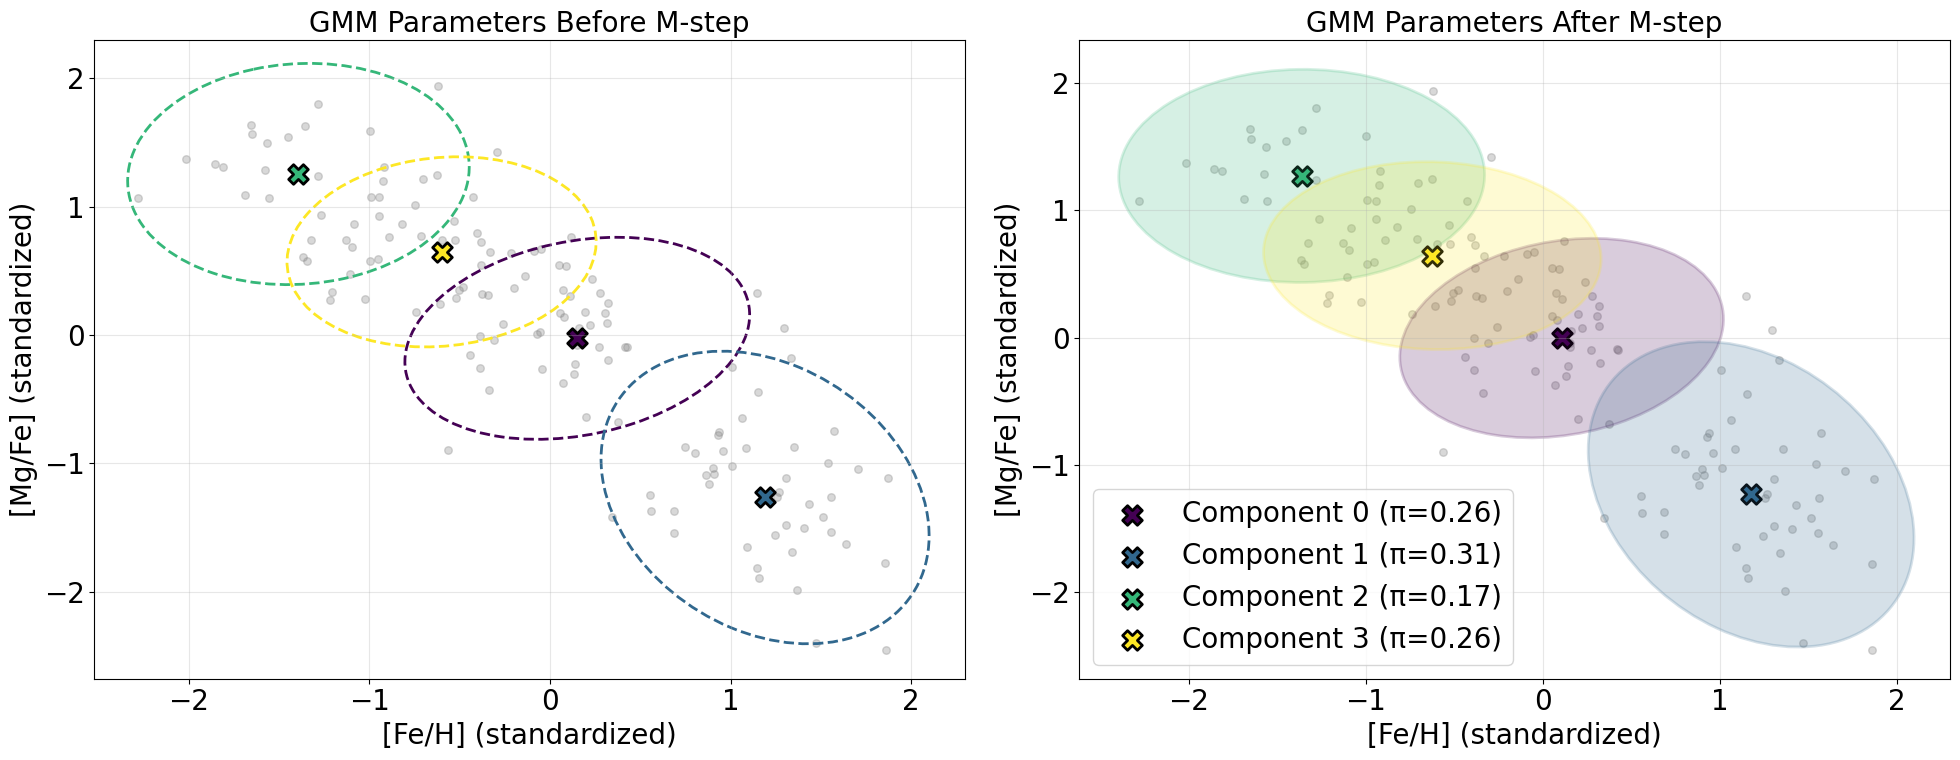

In [19]:
# Visualize parameters before and after M-step
plt.figure(figsize=(20, 8))

# Before M-step
plt.subplot(1, 2, 1)
plt.scatter(X_std[:, 0], X_std[:, 1], s=30, alpha=0.3, color='gray')

for i in range(4):
    # Plot old parameters
    plt.scatter(means[i, 0], means[i, 1], s=200, marker='X', 
                color=colors[i], edgecolor='black', linewidth=2)
    
    # Plot old covariance ellipse
    eigenvalues, eigenvectors = np.linalg.eigh(covariances[i])
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * 2.447 * np.sqrt(eigenvalues)
    
    ellipse = patches.Ellipse(xy=means[i], width=width, height=height, 
                             angle=angle, facecolor='none', 
                             edgecolor=colors[i], linewidth=2, linestyle='--')
    plt.gca().add_patch(ellipse)

plt.xlabel('[Fe/H] (standardized)')
plt.ylabel('[Mg/Fe] (standardized)')
plt.title('GMM Parameters Before M-step')
plt.grid(True, alpha=0.3)

# After M-step
plt.subplot(1, 2, 2)
plt.scatter(X_std[:, 0], X_std[:, 1], s=30, alpha=0.3, color='gray')

for i in range(4):
    # Plot new parameters
    plt.scatter(new_means[i, 0], new_means[i, 1], s=200, marker='X', 
                color=colors[i], edgecolor='black', linewidth=2, 
                label=f'Component {i} (π={new_weights[i]:.2f})')
    
    # Plot new covariance ellipse
    eigenvalues, eigenvectors = np.linalg.eigh(new_covariances[i])
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * 2.447 * np.sqrt(eigenvalues)
    
    ellipse = patches.Ellipse(xy=new_means[i], width=width, height=height, 
                             angle=angle, facecolor=colors[i], alpha=0.2, 
                             edgecolor=colors[i], linewidth=2)
    plt.gca().add_patch(ellipse)

plt.xlabel('[Fe/H] (standardized)')
plt.ylabel('[Mg/Fe] (standardized)')
plt.title('GMM Parameters After M-step')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## The Complete EM Algorithm for GMM

We now combine the E-step and M-step into the complete Expectation-Maximization algorithm for Gaussian Mixture Models. The EM algorithm provides an elegant solution to a challenging optimization problem: maximizing the likelihood of a mixture model where both the parameters and the component assignments are unknown.

The algorithm proceeds iteratively:
1. **Initialize** parameters (weights, means, covariances)
2. **E-step**: Compute responsibilities given current parameters
3. **M-step**: Update parameters given current responsibilities
4. **Repeat** until the log-likelihood converges

A key theoretical guarantee of EM is that the log-likelihood never decreases—each iteration either improves the fit or maintains it. This monotonic improvement ensures convergence to a local maximum, though not necessarily the global optimum (hence the importance of good initialization).

For our stellar populations, convergence typically occurs within 10-50 iterations, depending on the complexity of the abundance distribution and the quality of initialization. We monitor convergence by tracking the change in log-likelihood between iterations, stopping when this change falls below a threshold.

Let's implement the complete EM algorithm and apply it to uncover the stellar populations in Sculptor:


In [20]:
def fit_gmm(X, k, max_iter=100, tol=1e-4, init_method='kmeans++', random_state=None):
    """
    Fit a Gaussian Mixture Model using the EM algorithm
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of components
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance (change in log-likelihood)
    init_method : str
        Initialization method for K-means
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    weights : array, shape (k,)
        Final mixture weights
    means : array, shape (k, n_features)
        Final component means
    covariances : array, shape (k, n_features, n_features)
        Final component covariances
    responsibilities : array, shape (n_samples, k)
        Final responsibilities
    log_likelihood : float
        Final log-likelihood
    n_iter : int
        Number of iterations run
    history : dict
        Dictionary containing convergence history
    """
    # Initialize parameters
    weights, means, covariances = initialize_gmm(X, k, init_method, random_state)
    
    # Initialize history tracking
    history = {
        'log_likelihood': [],
        'weights': [weights.copy()],
        'means': [means.copy()],
        'covariances': [covariances.copy()]
    }
    
    # Initialize log-likelihood
    old_log_likelihood = -np.inf
    
    # EM iterations
    for iteration in range(max_iter):
        # E-step
        responsibilities, log_likelihood = e_step(X, weights, means, covariances)
        history['log_likelihood'].append(log_likelihood)
        
        # Check convergence
        log_likelihood_change = log_likelihood - old_log_likelihood
        if log_likelihood_change < tol:
            print(f"Converged after {iteration + 1} iterations")
            break
        
        old_log_likelihood = log_likelihood
        
        # M-step
        weights, means, covariances = m_step(X, responsibilities)
        
        # Store updated parameters
        history['weights'].append(weights.copy())
        history['means'].append(means.copy())
        history['covariances'].append(covariances.copy())
        
        # Print progress every 10 iterations
        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: Log-likelihood = {log_likelihood:.2f}, Change = {log_likelihood_change:.6f}")
    
    # Final E-step for responsibilities
    responsibilities, log_likelihood = e_step(X, weights, means, covariances)
    
    return weights, means, covariances, responsibilities, log_likelihood, iteration + 1, history

Fitting GMM with 4 components...
K-means converged after 5 iterations
Iteration 10: Log-likelihood = -283.08, Change = 0.047904
Iteration 20: Log-likelihood = -282.39, Change = 0.138064
Iteration 30: Log-likelihood = -278.48, Change = 0.157246
Iteration 40: Log-likelihood = -278.25, Change = 0.001896
Iteration 50: Log-likelihood = -278.25, Change = 0.000147
Converged after 56 iterations

Final log-likelihood: -278.25
Converged in 56 iterations


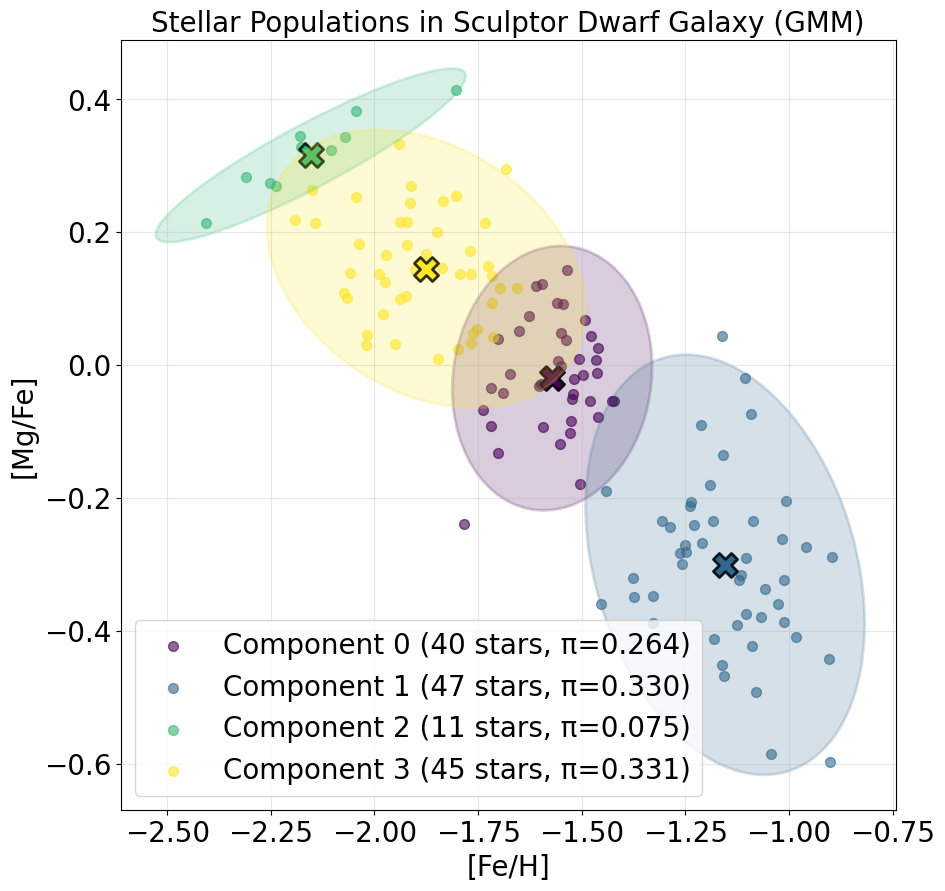


GMM component properties:

Component 0:
  Weight: 0.264
  Mean: [Fe/H] = -1.571, [Mg/Fe] = -0.020
  Stars assigned: 40
  [Fe/H] range: [-1.783, -1.423]
  [Mg/Fe] range: [-0.240, 0.143]

Component 1:
  Weight: 0.330
  Mean: [Fe/H] = -1.154, [Mg/Fe] = -0.301
  Stars assigned: 47
  [Fe/H] range: [-1.453, -0.897]
  [Mg/Fe] range: [-0.598, 0.043]

Component 2:
  Weight: 0.075
  Mean: [Fe/H] = -2.154, [Mg/Fe] = 0.315
  Stars assigned: 11
  [Fe/H] range: [-2.407, -1.803]
  [Mg/Fe] range: [0.214, 0.414]

Component 3:
  Weight: 0.331
  Mean: [Fe/H] = -1.876, [Mg/Fe] = 0.144
  Stars assigned: 45
  [Fe/H] range: [-2.192, -1.657]
  [Mg/Fe] range: [0.009, 0.333]


In [21]:
# Fit GMM with 4 components
print("Fitting GMM with 4 components...")
weights, means, covariances, responsibilities, log_likelihood, n_iter, history = fit_gmm(
    X_std, k=4, init_method='kmeans++', random_state=42)

print(f"\nFinal log-likelihood: {log_likelihood:.2f}")
print(f"Converged in {n_iter} iterations")

# Visualize GMM results in original abundance space
plt.figure(figsize=(10, 10))

# Convert parameters back to original scale
means_orig = means * std_X + mean_X
max_resp_idx = np.argmax(responsibilities, axis=1)

# Plot data points colored by component
for i in range(4):
    mask = max_resp_idx == i
    plt.scatter(X[mask, 0], X[mask, 1], 
               c=[colors[i]], alpha=0.6, s=50, 
               label=f'Component {i} ({np.sum(mask)} stars, π={weights[i]:.3f})')

# Plot Gaussian components
for i in range(4):
    # Plot mean
    plt.scatter(means_orig[i, 0], means_orig[i, 1], s=300, marker='X', 
                color=colors[i], edgecolor='black', linewidth=2)
    
    # Transform covariance to original scale
    cov_orig = np.diag(std_X) @ covariances[i] @ np.diag(std_X)
    
    # Plot covariance ellipse
    eigenvalues, eigenvectors = np.linalg.eigh(cov_orig)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * 2.447 * np.sqrt(eigenvalues)
    
    ellipse = patches.Ellipse(xy=means_orig[i], width=width, height=height, 
                             angle=angle, facecolor=colors[i], alpha=0.2, 
                             edgecolor=colors[i], linewidth=2)
    plt.gca().add_patch(ellipse)

plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.title('Stellar Populations in Sculptor Dwarf Galaxy (GMM)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Report component properties
print("\nGMM component properties:")
for i in range(4):
    mask = max_resp_idx == i
    component_fe_h = X[mask, 0]
    component_mg_fe = X[mask, 1]
    
    print(f"\nComponent {i}:")
    print(f"  Weight: {weights[i]:.3f}")
    print(f"  Mean: [Fe/H] = {means_orig[i, 0]:.3f}, [Mg/Fe] = {means_orig[i, 1]:.3f}")
    print(f"  Stars assigned: {np.sum(mask)}")
    print(f"  [Fe/H] range: [{np.min(component_fe_h):.3f}, {np.max(component_fe_h):.3f}]")
    print(f"  [Mg/Fe] range: [{np.min(component_mg_fe):.3f}, {np.max(component_mg_fe):.3f}]")

## Visualizing GMM Convergence

The EM algorithm's convergence behavior provides insight into both the algorithm's efficiency and the underlying data structure. By tracking the log-likelihood evolution and parameter trajectories, we can understand how the algorithm progressively refines its model of the stellar populations.

Unlike K-means, which typically shows rapid initial movement followed by fine-tuning, GMM convergence often exhibits more gradual refinement. This reflects the additional complexity of estimating full covariance matrices and the soft nature of the assignments. The log-likelihood serves as our objective function, and its monotonic increase confirms proper algorithm implementation.

Let's visualize the convergence process to understand how our model evolved toward the final solution:

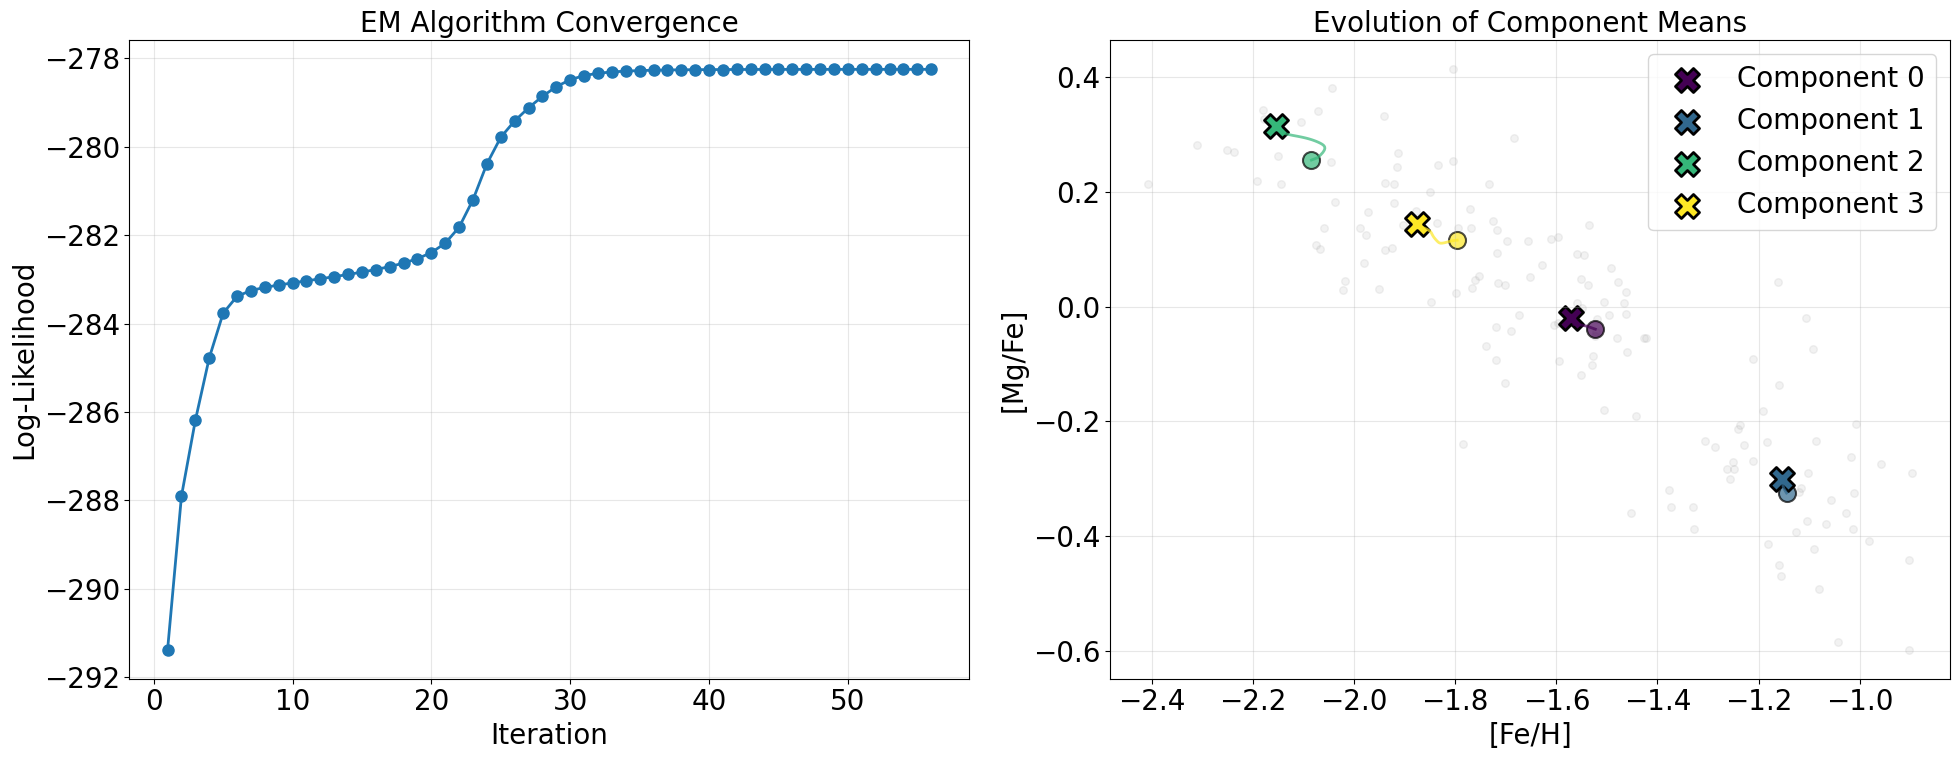

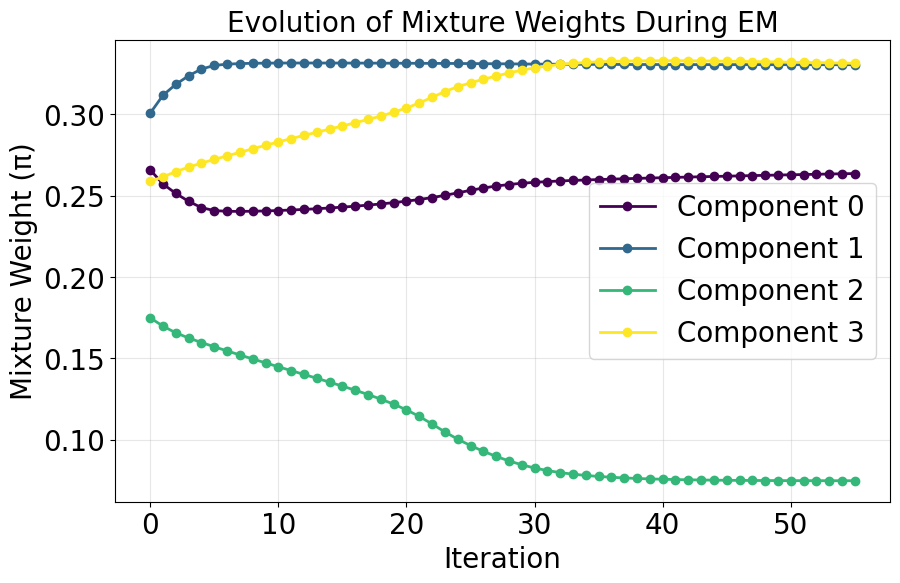

In [23]:
def visualize_gmm_convergence(history):
    """Visualize GMM convergence: log-likelihood evolution and parameter changes"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Left plot: Log-likelihood evolution
    log_likelihoods = history['log_likelihood']
    ax1.plot(range(1, len(log_likelihoods) + 1), log_likelihoods, 
            'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Log-Likelihood')
    ax1.set_title('EM Algorithm Convergence')
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Mean trajectories in original space
    means_history = history['means']
    ax2.scatter(X[:, 0], X[:, 1], alpha=0.1, s=30, c='gray')
    
    # Plot trajectory for each component
    for i in range(4):
        # Extract trajectory for component i
        trajectory = np.array([m[i] * std_X + mean_X for m in means_history])
        
        # Plot path
        ax2.plot(trajectory[:, 0], trajectory[:, 1], 
                '-', color=colors[i], alpha=0.7, linewidth=2)
        
        # Mark start and end
        ax2.scatter(trajectory[0, 0], trajectory[0, 1], 
                   c=[colors[i]], s=150, marker='o', edgecolor='black', 
                   linewidth=1.5, alpha=0.7)
        ax2.scatter(trajectory[-1, 0], trajectory[-1, 1], 
                   c=[colors[i]], s=300, marker='X', edgecolor='black', 
                   linewidth=2, label=f'Component {i}')
    
    ax2.set_xlabel('[Fe/H]')
    ax2.set_ylabel('[Mg/Fe]')
    ax2.set_title('Evolution of Component Means')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize convergence
visualize_gmm_convergence(history)

# Show evolution of mixture weights
plt.figure(figsize=(10, 6))
weights_history = np.array(history['weights'])

for i in range(4):
    plt.plot(range(len(weights_history)), weights_history[:, i], 
            'o-', color=colors[i], label=f'Component {i}', 
            linewidth=2, markersize=6)

plt.xlabel('Iteration')
plt.ylabel('Mixture Weight (π)')
plt.title('Evolution of Mixture Weights During EM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Model Selection for GMM: Information Criteria

While K-means relied on the heuristic elbow method for selecting the number of clusters, GMMs enable a more principled approach through information criteria. These criteria balance model fit against complexity, addressing the fundamental trade-off in model selection: more components always improve the likelihood, but at the cost of increased parameters and potential overfitting.

Two widely-used criteria provide complementary perspectives:

**Bayesian Information Criterion (BIC)**
$$\text{BIC} = -2\ln(\hat{L}) + P\ln(N)$$

**Akaike Information Criterion (AIC)**
$$\text{AIC} = -2\ln(\hat{L}) + 2P$$

where $\hat{L}$ is the maximized likelihood, $P$ is the number of parameters, and $N$ is the sample size. Lower values indicate better models.

The key difference lies in the complexity penalty. BIC's penalty grows with sample size ($P\ln(N)$), making it increasingly conservative for larger datasets. AIC's fixed penalty ($2P$) focuses on predictive performance rather than identifying the "true" model. For our stellar data with hundreds of stars, this difference can lead to substantially different conclusions.

For a $K$-component GMM in $D$ dimensions, the parameter count is:
- Mixture weights: $K-1$ (constrained to sum to 1)
- Means: $K \times D$
- Covariances: $K \times D(D+1)/2$ (symmetric matrices)

In our 2D case: $P = (K-1) + 2K + 3K = 6K - 1$

Let's compute these criteria across different numbers of components to determine the optimal model complexity for Sculptor's stellar populations:

In [24]:
def compute_aic_bic(log_likelihood, n_samples, n_components, n_dimensions):
    """
    Compute AIC and BIC for model selection
    
    Parameters:
    -----------
    log_likelihood : float
        Log-likelihood of the model
    n_samples : int
        Number of data points
    n_components : int
        Number of Gaussian components
    n_dimensions : int
        Number of dimensions
    
    Returns:
    --------
    aic : float
        Akaike Information Criterion
    bic : float
        Bayesian Information Criterion
    """
    # Number of free parameters for GMM
    # Weights: K-1 (sum to 1 constraint)
    # Means: K*D 
    # Covariances: K*D*(D+1)/2 (symmetric)
    n_parameters = (n_components - 1) + \
                   (n_components * n_dimensions) + \
                   (n_components * n_dimensions * (n_dimensions + 1) // 2)
    
    # Compute criteria
    aic = -2 * log_likelihood + 2 * n_parameters
    bic = -2 * log_likelihood + n_parameters * np.log(n_samples)
    
    return aic, bic

def gmm_model_selection(X, k_range=range(1, 10), init_method='kmeans++', random_state=42):
    """
    Fit GMMs with different numbers of components and compute information criteria
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_dimensions)
        The input data
    k_range : iterable
        Range of k values to try
    init_method : str
        Initialization method
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    results : dict
        Dictionary containing results for each k
    """
    n_samples, n_dimensions = X.shape
    
    results = {
        'k': list(k_range),
        'log_likelihood': [],
        'aic': [],
        'bic': [],
        'n_parameters': []
    }
    
    for k in k_range:
        print(f"\nFitting GMM with {k} components...")
        
        # Fit GMM
        weights, means, covariances, _, log_likelihood, n_iter, _ = fit_gmm(
            X, k, init_method=init_method, random_state=random_state)
        
        # Compute information criteria
        aic, bic = compute_aic_bic(log_likelihood, n_samples, k, n_dimensions)
        
        # Calculate number of parameters
        n_params = (k - 1) + (k * n_dimensions) + \
                   (k * n_dimensions * (n_dimensions + 1) // 2)
        
        # Store results
        results['log_likelihood'].append(log_likelihood)
        results['aic'].append(aic)
        results['bic'].append(bic)
        results['n_parameters'].append(n_params)
        
        print(f"  Log-likelihood: {log_likelihood:.2f}")
        print(f"  Parameters: {n_params}")
        print(f"  AIC: {aic:.2f}")
        print(f"  BIC: {bic:.2f}")
    
    return results


Fitting GMM with 1 components...
K-means converged after 2 iterations
Converged after 3 iterations
  Log-likelihood: -308.87
  Parameters: 5
  AIC: 627.73
  BIC: 642.54

Fitting GMM with 2 components...
K-means converged after 4 iterations
Iteration 10: Log-likelihood = -293.05, Change = 0.013240
Iteration 20: Log-likelihood = -292.99, Change = 0.002280
Iteration 30: Log-likelihood = -292.98, Change = 0.000181
Converged after 33 iterations
  Log-likelihood: -292.98
  Parameters: 11
  AIC: 607.96
  BIC: 640.55

Fitting GMM with 3 components...
K-means converged after 6 iterations
Iteration 10: Log-likelihood = -287.07, Change = 0.034669
Iteration 20: Log-likelihood = -286.88, Change = 0.010555
Iteration 30: Log-likelihood = -286.82, Change = 0.003980
Iteration 40: Log-likelihood = -286.79, Change = 0.001679
Iteration 50: Log-likelihood = -286.78, Change = 0.000751
Iteration 60: Log-likelihood = -286.77, Change = 0.000347
Iteration 70: Log-likelihood = -286.77, Change = 0.000163
Converg

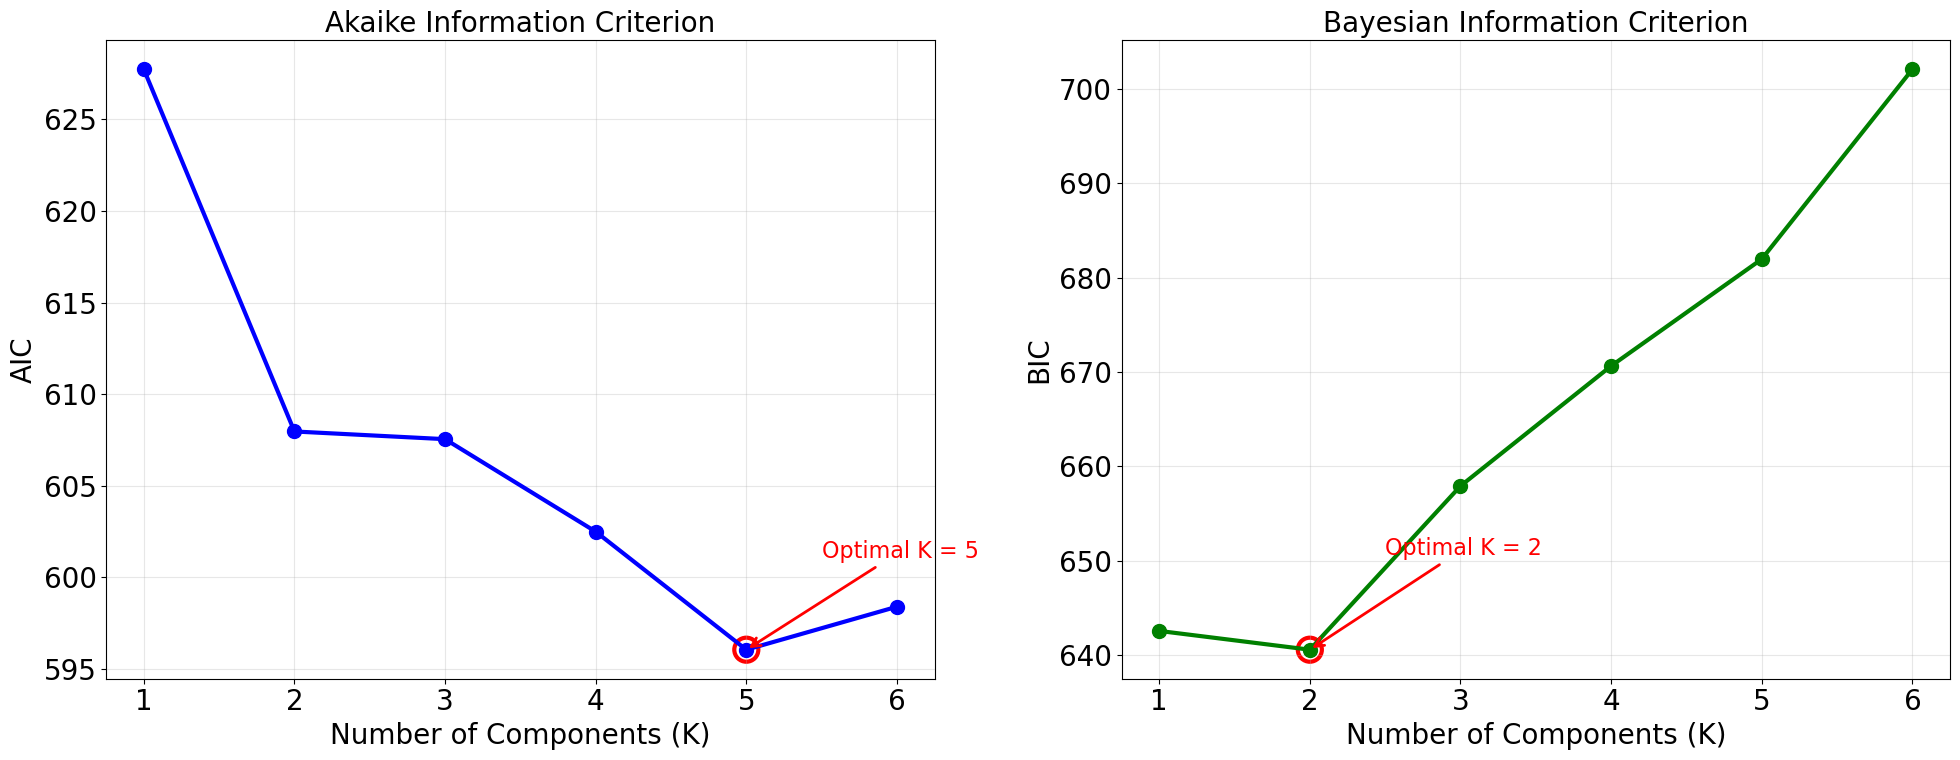


Model selection summary:
AIC suggests K = 5 components
BIC suggests K = 2 components

Relative improvement from K-1 to K:
K=1 to K=2: AIC +3.1%, BIC +0.3%
K=2 to K=3: AIC +0.1%, BIC -2.7%
K=3 to K=4: AIC +0.8%, BIC -1.9%
K=4 to K=5: AIC +1.1%, BIC -1.7%
K=5 to K=6: AIC -0.4%, BIC -3.0%


In [25]:
# Perform model selection for k = 1 to 6
k_range = range(1, 7)
results = gmm_model_selection(X_std, k_range=k_range)

# Visualize information criteria
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot AIC
ax1.plot(results['k'], results['aic'], 'o-', linewidth=3, markersize=10, color='blue')
ax1.set_xlabel('Number of Components (K)')
ax1.set_ylabel('AIC')
ax1.set_title('Akaike Information Criterion')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(results['k'])

# Find and mark minimum AIC
min_aic_idx = np.argmin(results['aic'])
min_aic_k = results['k'][min_aic_idx]
ax1.scatter(min_aic_k, results['aic'][min_aic_idx], 
           s=300, facecolors='none', edgecolors='red', linewidth=3)
ax1.annotate(f'Optimal K = {min_aic_k}',
            xy=(min_aic_k, results['aic'][min_aic_idx]),
            xytext=(min_aic_k + 0.5, results['aic'][min_aic_idx] + 5),
            arrowprops=dict(arrowstyle='->', color='red', linewidth=2),
            fontsize=16, color='red')

# Plot BIC
ax2.plot(results['k'], results['bic'], 'o-', linewidth=3, markersize=10, color='green')
ax2.set_xlabel('Number of Components (K)')
ax2.set_ylabel('BIC')
ax2.set_title('Bayesian Information Criterion')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(results['k'])

# Find and mark minimum BIC
min_bic_idx = np.argmin(results['bic'])
min_bic_k = results['k'][min_bic_idx]
ax2.scatter(min_bic_k, results['bic'][min_bic_idx], 
           s=300, facecolors='none', edgecolors='red', linewidth=3)
ax2.annotate(f'Optimal K = {min_bic_k}',
            xy=(min_bic_k, results['bic'][min_bic_idx]),
            xytext=(min_bic_k + 0.5, results['bic'][min_bic_idx] + 10),
            arrowprops=dict(arrowstyle='->', color='red', linewidth=2),
            fontsize=16, color='red')

plt.tight_layout()
plt.show()

print(f"\nModel selection summary:")
print(f"AIC suggests K = {min_aic_k} components")
print(f"BIC suggests K = {min_bic_k} components")

# Show relative differences
print("\nRelative improvement from K-1 to K:")
for i in range(1, len(results['k'])):
    aic_improvement = 100 * (results['aic'][i-1] - results['aic'][i]) / abs(results['aic'][i-1])
    bic_improvement = 100 * (results['bic'][i-1] - results['bic'][i]) / abs(results['bic'][i-1])
    print(f"K={results['k'][i-1]} to K={results['k'][i]}: AIC {aic_improvement:+.1f}%, BIC {bic_improvement:+.1f}%")

## Interpreting Model Selection Results

The divergence between AIC and BIC recommendations—5 versus 2 components—exemplifies a fundamental tension in model selection. This disagreement reflects their different philosophical approaches:

**BIC's Conservative Choice (K=2)**: By selecting only 2 components, BIC identifies the most prominent structure in the data—likely separating metal-poor from metal-rich populations. This parsimonious model captures the primary chemical evolution trend while avoiding potential overfitting to smaller substructures.

**AIC's Detailed Model (K=5)**: The 5-component model suggested by AIC reveals finer structure within the stellar populations. Given AIC's focus on predictive accuracy rather than model truth, this suggestion implies that additional components capture meaningful variance in the data, even if they represent smaller or partially overlapping populations.

This discrepancy is particularly intriguing in light of the episodic star formation hypothesis. If Sculptor experienced multiple discrete bursts of star formation, we would expect to see several distinct populations in chemical space. The AIC's preference for 5 components might be detecting these subtle signatures that BIC's stronger complexity penalty obscures.

Let's examine the 5-component model to understand what additional structure AIC has identified:

Fitting GMM with K=5 components as suggested by AIC...
K-means converged after 9 iterations
Iteration 10: Log-likelihood = -273.56, Change = 0.093226
Iteration 20: Log-likelihood = -269.91, Change = 0.223484
Iteration 30: Log-likelihood = -269.04, Change = 0.008514
Iteration 40: Log-likelihood = -269.03, Change = 0.000296
Converged after 45 iterations

5-component model statistics:
Log-likelihood: -269.02
Converged in 45 iterations


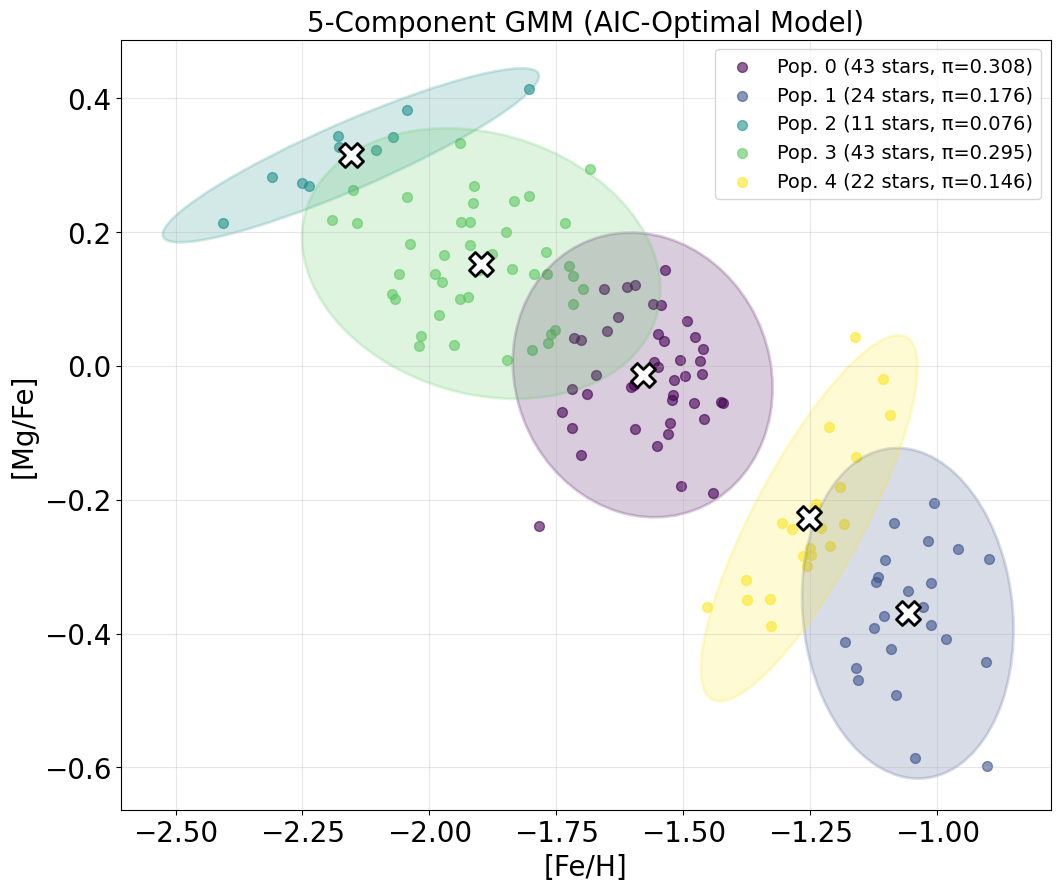


Population analysis (5-component model):

Population 0:
  Size: 43 stars (30.8% of total)
  Mean [Fe/H]: -1.580
  Mean [Mg/Fe]: -0.014
  [Fe/H] spread (1σ): ±0.094
  [Mg/Fe] spread (1σ): ±0.085

Population 1:
  Size: 24 stars (17.6% of total)
  Mean [Fe/H]: -1.058
  Mean [Mg/Fe]: -0.370
  [Fe/H] spread (1σ): ±0.080
  [Mg/Fe] spread (1σ): ±0.098

Population 2:
  Size: 11 stars (7.6% of total)
  Mean [Fe/H]: -2.155
  Mean [Mg/Fe]: 0.315
  [Fe/H] spread (1σ): ±0.151
  [Mg/Fe] spread (1σ): ±0.053

Population 3:
  Size: 43 stars (29.5% of total)
  Mean [Fe/H]: -1.898
  Mean [Mg/Fe]: 0.153
  [Fe/H] spread (1σ): ±0.132
  [Mg/Fe] spread (1σ): ±0.080

Population 4:
  Size: 22 stars (14.6% of total)
  Mean [Fe/H]: -1.252
  Mean [Mg/Fe]: -0.228
  [Fe/H] spread (1σ): ±0.086
  [Mg/Fe] spread (1σ): ±0.110


In [26]:
# Fit the 5-component model suggested by AIC
print("Fitting GMM with K=5 components as suggested by AIC...")
weights_5, means_5, covariances_5, responsibilities_5, log_likelihood_5, n_iter_5, history_5 = fit_gmm(
    X_std, k=5, init_method='kmeans++', random_state=42)

print(f"\n5-component model statistics:")
print(f"Log-likelihood: {log_likelihood_5:.2f}")
print(f"Converged in {n_iter_5} iterations")

# Visualize the 5-component model
plt.figure(figsize=(12, 10))

# Convert to original scale
means_5_orig = means_5 * std_X + mean_X
max_resp_idx_5 = np.argmax(responsibilities_5, axis=1)

# Use a colormap with 5 distinct colors
colors_5 = plt.cm.viridis(np.linspace(0, 1, 5))

# Plot data points colored by component
for i in range(5):
    mask = max_resp_idx_5 == i
    plt.scatter(X[mask, 0], X[mask, 1], 
               c=[colors_5[i]], alpha=0.6, s=50, 
               label=f'Pop. {i} ({np.sum(mask)} stars, π={weights_5[i]:.3f})')

# Plot Gaussian components
for i in range(5):
    # Plot mean
    plt.scatter(means_5_orig[i, 0], means_5_orig[i, 1], s=300, marker='X', 
                color='white', edgecolor='black', linewidth=2, zorder=10)
    
    # Transform covariance to original scale
    cov_5_orig = np.diag(std_X) @ covariances_5[i] @ np.diag(std_X)
    
    # Plot covariance ellipse
    eigenvalues, eigenvectors = np.linalg.eigh(cov_5_orig)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * 2.447 * np.sqrt(eigenvalues)
    
    ellipse = patches.Ellipse(xy=means_5_orig[i], width=width, height=height, 
                             angle=angle, facecolor=colors_5[i], alpha=0.2, 
                             edgecolor=colors_5[i], linewidth=2)
    plt.gca().add_patch(ellipse)

plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.title('5-Component GMM (AIC-Optimal Model)')
plt.legend(loc='best', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Analyze the 5 populations
print("\nPopulation analysis (5-component model):")
for i in range(5):
    mask = max_resp_idx_5 == i
    pop_fe_h = X[mask, 0]
    pop_mg_fe = X[mask, 1]
    
    print(f"\nPopulation {i}:")
    print(f"  Size: {np.sum(mask)} stars ({100*weights_5[i]:.1f}% of total)")
    print(f"  Mean [Fe/H]: {means_5_orig[i, 0]:.3f}")
    print(f"  Mean [Mg/Fe]: {means_5_orig[i, 1]:.3f}")
    print(f"  [Fe/H] spread (1σ): ±{np.std(pop_fe_h):.3f}")
    print(f"  [Mg/Fe] spread (1σ): ±{np.std(pop_mg_fe):.3f}")

The 5-component model reveals rich structure in Sculptor's stellar population, with distinct groups spanning a range of metallicities and α-element abundances. Each population's chemical signature potentially marks a distinct burst of star formation, separated by quiescent periods where Type Ia supernovae dominated the chemical enrichment. This granular view, while more complex than the 2-component model preferred by BIC, aligns with theoretical predictions for episodic star formation in dwarf galaxies.

The choice between models ultimately depends on the scientific question at hand. For identifying the most robust, primary structure, the 2-component model suffices. For exploring the detailed star formation history and testing specific predictions about burst timescales, the 5-component model provides the necessary resolution. This exemplifies why model selection remains as much art as science, requiring both statistical rigor and astrophysical insight.

## Summary

This tutorial has demonstrated how clustering algorithms reveal structure in astronomical data through the analysis of stellar chemical abundances in the Sculptor dwarf spheroidal galaxy. By building K-means and Gaussian Mixture Models from scratch, we developed deep intuition for their mathematical foundations and practical applications.

The key insights from our analysis include:

**Algorithmic Understanding**: K-means provides efficient partitioning through iterative refinement of cluster centers, but assumes spherical, equally-sized clusters. GMMs extend this framework probabilistically, allowing for elliptical clusters of varying sizes and providing uncertainty quantification through soft assignments.

**Initialization Matters**: K-means++ initialization dramatically improves convergence speed and solution quality compared to random initialization, spreading initial centroids across the data space to avoid poor local minima.

**Model Selection Philosophy**: The divergence between AIC (suggesting 5 components) and BIC (suggesting 2 components) reflects their different goals—AIC optimizes predictive performance while BIC seeks the most parsimonious model. This difference becomes particularly pronounced with the modest sample sizes typical in astronomical spectroscopy.

**Astrophysical Discoveries**: The multimodal structure in Sculptor's [Fe/H]-[Mg/Fe] distribution provides compelling evidence for episodic star formation. The discrete populations, separated by chemical gaps consistent with ~300 Myr quiescent periods, reveal how stellar chemistry preserves a detailed record of a galaxy's assembly history.

**Practical Implementation**: Building these algorithms from first principles—from distance calculations through convergence criteria—provides the deep understanding necessary for their effective application. This foundation enables informed choices about preprocessing, initialization, convergence assessment, and interpretation of results.

The progression from K-means to GMMs exemplifies a broader principle in statistical machine learning: starting with simple, interpretable models before adding complexity to capture real-world nuances. In astronomy, where we often seek to understand the physical processes behind observed patterns, this incremental approach helps distinguish robust findings from artifacts of our analysis choices.